# CompChem-mini-suites


In [ ]:
# Import Libraries
import time
import sqlite3
import numpy as np
from numpy import trapezoid as simps
import pandas as pd
from scipy.special import erf
from scipy.special import gamma
from scipy.linalg import eigh
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
import numba
from numba import njit, prange, jit, types
from numba.typed import List
from numba.experimental import jitclass
from numba import float64, int64
import matplotlib.pyplot as plt
from __future__ import annotations
from IPython.display import display, Markdown
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from math import pi, sqrt, exp, erf

# Suite 1: Quantum and Classical Harmonic Oscillators

## Part 1-1: Dimensionless Formulation of Harmonic Oscillator Hamiltonian

### Choosing natural scales for the 1‑D harmonic oscillator  

We can start from the Hamiltonian below

$$
\hat H \;=\; -\frac{\hbar^{2}}{2m}\,\frac{d^{2}}{dx^{2}}\;+\;\frac12\,k\,x^{2},
\qquad\text{with}\quad k = m\omega^{2},\; \omega=\sqrt{k/m}
$$

---

#### 1.  A dimensionless position  

First, we want to pick the characteristic **length**

$$
\boxed{\;\ell \;=\;\sqrt{\frac{\hbar}{m\omega}}\;}
$$  
and we define the dimension‑less coordinate

$$
x^{*}\;=\;\frac{x}{\ell}\quad\Longrightarrow\quad
\frac{d}{dx}\;=\;\frac{1}{\ell}\frac{d}{dx^{*}},\;
\frac{d^{2}}{dx^{2}}\;=\;\frac{1}{\ell^{2}}\frac{d^{2}}{dx^{*2}}.
$$

---

#### 2.  Rewriting the kinetic term , we get that

$$
-\frac{\hbar^{2}}{2m}\,\frac{d^{2}}{dx^{2}}
\;=\;
-\frac{\hbar^{2}}{2m}\,\frac{1}{\ell^{2}}\frac{d^{2}}{dx^{*2}}
\;=\;
-\frac{\hbar\omega}{2}\,\frac{d^{2}}{dx^{*2}}.
$$

*(Used $\ell^{2}=\hbar/(m\omega)$.)*

---

#### 3.  Now, rewriting the potential term  

$$
\frac12\,k\,x^{2}
\;=\;
\frac12\,m\omega^{2}\,\ell^{2}\,x^{*2}
\;=\;
\frac12\,m\omega^{2}\,\frac{\hbar}{m\omega}\,x^{*2}
\;=\;
\frac{\hbar\omega}{2}\;x^{*2}.
$$

---

#### 4.  Collecting terms and choose an energy scale  

Both pieces carry the **same prefactor**

$$
\frac{\hbar\omega}{2}.
$$

Taking this as the unit of energy

$$
\boxed{\;\varepsilon \;=\;\frac{\hbar\omega}{2}\;}
$$

and defining the dimension‑less Hamiltonian $\hat H^{*} = \hat H/\varepsilon$:

$$
\boxed{\;
\hat H^{*}
\;=\;
-\frac{d^{2}}{dx^{*2}}\;+\;x^{*2}\;
}.
$$

---
In summary, in the scaled units:

* distances are measured in multiples of $\ell=\sqrt{\hbar/(m\omega)}$;
* energies are measured in multiples of $\varepsilon=\hbar\omega/2$.

With these natural units the harmonic‑oscillator Hamiltonian is free of physical constants and takes the fully dimensionless form  

$$
\hat H^{*} = -\dfrac{d^{2}}{dx^{*2}} + x^{*2}.
$$

## Part 1-2: Quantum Solutions and Bose-Einstein Statistics of Harmonic Oscillator

<ipython-input-2-e103e2586b35>:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.trapz(np.abs(psi)**2, x)


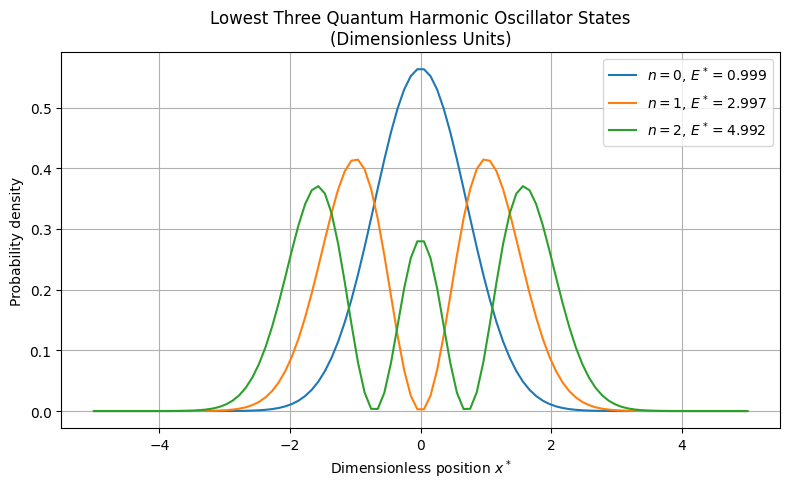

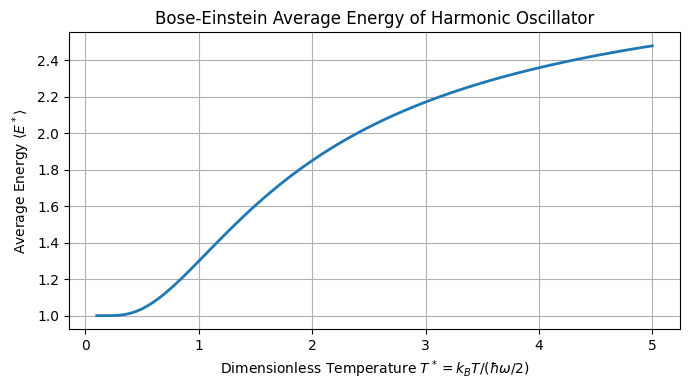

n = 0, E* = 0.999362
n = 1, E* = 2.996808
n = 2, E* = 4.991696


In [ ]:
# -----  Parameters ------ #
N = 100              # number of grid points
x_max = 5.0          # domain for x*
x = np.linspace(-x_max, x_max, N)
dx = x[1] - x[0]

# ===== Kinetic energy operator (finite difference method) ===== #
T = -np.diag(np.ones(N-1), -1) + 2*np.diag(np.ones(N), 0) - np.diag(np.ones(N-1), 1)
T *= 1 / dx**2

# ===== Potential energy operator ===== #
V = np.diag(x**2)

# ===== Hamiltonian in reduced units (scaled by ħω/2) ===== #
H = T + V

# ----- Diagonalize the Hamiltonian ----- #
e_vals, e_vecs = eigh(H)
energies = e_vals[:3]           # Three lowest eigenvalues
wavefuncs = e_vecs[:, :3]       # Corresponding eigenfunctions

# ===== Normalize wavefunctions and compute probability densities ===== #
prob_densities = []
for i in range(3):
    psi = wavefuncs[:, i]
    norm = np.trapz(np.abs(psi)**2, x)
    prob_densities.append(np.abs(psi)**2 / norm)

# ===== Plots probability densities ===== #
plt.figure(figsize=(8, 5))
for n, prob in enumerate(prob_densities):
    plt.plot(x, prob, label=f"$n={n}$, $E^*={energies[n]:.3f}$")

plt.title("Lowest Three Quantum Harmonic Oscillator States\n(Dimensionless Units)")
plt.xlabel("Dimensionless position $x^*$")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  ----- Bose-Einstein average energy function  ----- #
def bose_avg_energy(energies, T_star):
    energies = np.array(energies)
    weights = np.exp(-energies / T_star)
    Z = np.sum(weights)
    avg_E = np.sum(energies * weights) / Z
    return avg_E

# ===== Computing average energy over a range of dimensionless temperatures ===== #
T_stars = np.linspace(0.1, 5.0, 100)
avg_Es = [bose_avg_energy(energies, T) for T in T_stars]

# ===== Plotting average energy vs. temperature ===== #
plt.figure(figsize=(7, 4))
plt.plot(T_stars, avg_Es, label="Quantum Avg. Energy", linewidth=2)
plt.xlabel("Dimensionless Temperature $T^* = k_B T / (\hbar \omega / 2)$")
plt.ylabel("Average Energy $\langle E^* \\rangle$")
plt.title("Bose-Einstein Average Energy of Harmonic Oscillator")
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Outputting eigenvalues for reference ===== #
for n, E in enumerate(energies):
    print(f"n = {n}, E* = {E:.6f}")

## Part 1-3: Molecular Dynamics Simulation and Thermodynamic Properties of the Classical Oscillator

     T  Average E   Error E  Heat Capacity Cv
0  0.5   0.495476  0.001541          0.950067
1  1.0   1.048437  0.003143          0.987967
2  2.0   2.000891  0.006261          0.980018
3  4.0   4.205029  0.013123          1.076255


<ipython-input-13-60f6a06b79f2>:85: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  canonical /= np.trapz(canonical, bin_centers)


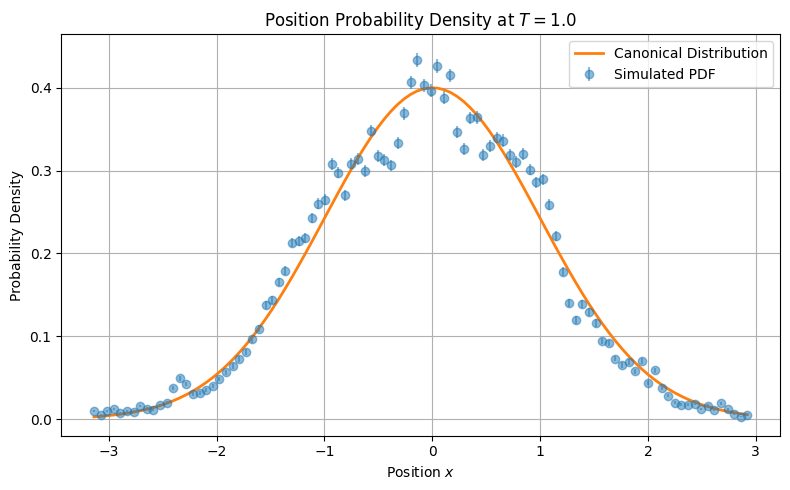

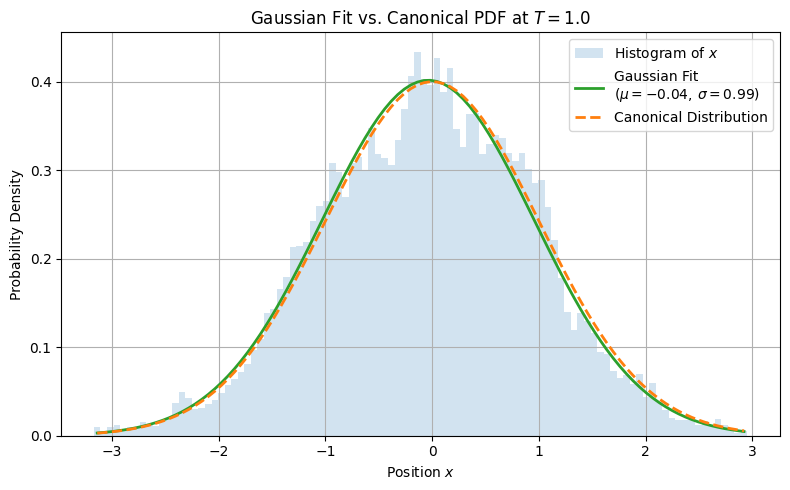

In [ ]:
# ----- Atomic units (a.u.) ----- #
mass = 1.0      # mass in atomic units
omega = 1.0     # angular frequency in atomic units
k_B = 1.0       # Boltzmann constant in atomic units

# ----- Velocity Verlet with Langevin thermostat ----- #
def velocity_verlet_langevin(T, dt, steps, gamma=1.0):
    """
    Integrate a 1D harmonic oscillator with a Langevin thermostat.
    Returns arrays of total energies and positions.
    """
    x = 0.0
    v = 0.0
    x_vals = []
    E_vals = []

    # Noise amplitude for stochastic force: sqrt(2*gamma*k_B*T*dt)/mass
    sigma = np.sqrt(2 * gamma * k_B * T * dt) / mass

    for _ in range(steps):
        # 1) Deterministic half-step velocity update
        a = -omega**2 * x
        v += 0.5 * a * dt

        # 2) Position update
        x += v * dt

        # 3) Complete deterministic velocity update
        a_new = -omega**2 * x
        v += 0.5 * a_new * dt

        # 4) Langevin thermostat: damping + random kick
        v = v * (1 - gamma * dt) + sigma * np.random.normal()

        # 5) Record position and total energy
        x_vals.append(x)
        E_kin = 0.5 * mass * v**2
        E_pot = 0.5 * mass * omega**2 * x**2
        E_vals.append(E_kin + E_pot)

    return np.array(E_vals), np.array(x_vals)

# ----- Estimate average energy and heat capacity with error bars ----- #
def estimate_Cv(E_vals, T):
    """
    Compute:
      • mean total energy
      • heat capacity via fluctuations
      • standard error of the mean energy
    """
    E = np.array(E_vals)
    mean_E = np.mean(E)
    var_E = np.var(E)
    Cv = var_E / (k_B * T**2)
    std_err = np.std(E) / np.sqrt(len(E))
    return Cv, mean_E, std_err

# ----- Simulation parameters ----- #
temps = [0.5, 1.0, 2.0, 4.0]  # temperatures to sample
dt = 0.01                    # time step
steps = 100_000              # number of MD steps per temperature

# ===== Run simulations across temperatures ===== #
results = []
for T in temps:
    E_vals, x_vals = velocity_verlet_langevin(T, dt, steps)
    Cv, avg_E, err_E = estimate_Cv(E_vals, T)
    results.append((T, avg_E, err_E, Cv))

# ===== Display results as DataFrame ===== #
df = pd.DataFrame(results,
                  columns=["T", "Average E", "Error E", "Heat Capacity Cv"])
print(df)

# ===== Plot histogram of x for T = 1.0 and compare with canonical distribution ===== #
T_plot = 1.0
E_vals_plot, x_vals_plot = velocity_verlet_langevin(T_plot, dt, steps)

# Compute normalized histogram (PDF)
hist, bins = np.histogram(x_vals_plot, bins=100, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# ----- Canonical (Boltzmann) distribution for harmonic oscillator ----- #
canonical = np.exp(-0.5 * mass * omega**2 * bin_centers**2 / (k_B * T_plot))
canonical /= np.trapz(canonical, bin_centers)

# ----- Error bars from Poisson statistics on histogram bin counts ----- #
bin_counts, _ = np.histogram(x_vals_plot, bins=100)
pdf_errors = np.sqrt(bin_counts) / (len(x_vals_plot) * (bins[1] - bins[0]))

# ===== Plotting ===== #
plt.figure(figsize=(8, 5))
plt.errorbar(bin_centers,
             hist,
             yerr=pdf_errors,
             fmt='o',
             alpha=0.5,
             label='Simulated PDF')
plt.plot(bin_centers,
         canonical,
         label='Canonical Distribution',
         linewidth=2)
plt.title("Position Probability Density at $T = 1.0$")
plt.xlabel("Position $x$")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Fit Gaussian Distribution ===== #
# Compute sample mean and standard deviation of the trajectory
mu    = np.mean(x_vals_plot)
sigma = np.std(x_vals_plot)

# Build Gaussian PDF at the bin centers
gauss_pdf = (1.0/(sigma * np.sqrt(2*np.pi))) * \
             np.exp(-0.5 * ((bin_centers - mu)/sigma)**2)

# ===== Plot: Histogram + Gaussian Fit + Canonical Curve ===== #
plt.figure(figsize=(8,5))

# 1) Underlying histogram of the data (for context)
plt.hist(x_vals_plot,
         bins=100,
         density=True,
         alpha=0.2,
         color='tab:blue',
         label='Histogram of $x$')

# 2) Smooth Gaussian fit
plt.plot(bin_centers,
         gauss_pdf,
         linestyle='-',
         color='tab:green',
         linewidth=2,
         label=f'Gaussian Fit\n($\\mu={mu:.2f},\\,\\sigma={sigma:.2f}$)')

# 3) Canonical (Boltzmann) distribution
plt.plot(bin_centers,
         canonical,
         linestyle='--',
         color='tab:orange',
         linewidth=2,
         label='Canonical Distribution')

plt.title("Gaussian Fit vs. Canonical PDF at $T=1.0$")
plt.xlabel("Position $x$")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Error Estimation Details for Part 1-3

In the molecular dynamics simulation, we compute three quantities with associated uncertainties: the average total energy, the heat capacity, and the position probability density. The following describes how each error bar was estimated.

#### 1. Error in Average Energy

Let $E_i$ be the total energy at time step $i$ over $N$ simulation steps. The average total energy is:

$$
\langle E \rangle = \frac{1}{N} \sum_{i=1}^{N} E_i
$$

The uncertainty (error bar) in $\langle E \rangle$ is estimated using the **standard error of the mean**:

$$\Delta \langle E \rangle = \frac{\sigma_E}{\sqrt{N}}, \quad \text{where} \quad \sigma_E^2 = \frac{1}{N} \sum_{i=1}^{N} (E_i - \langle E \rangle)^2$$

This accounts for statistical fluctuations in the instantaneous total energy.

#### 2. Error in Heat Capacity

The heat capacity at constant volume is computed using the **fluctuation formula**:

$$C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2}$$

We estimate the uncertainty in $C_V$ by propagating the variance of $E$. Although an exact error propagation would involve higher-order statistics, a reasonable approximation assumes that the uncertainty in $C_V$ is dominated by the uncertainty in the variance of $E$.

Alternatively, we could use bootstrapping or block averaging to obtain more precise error bars for $C_V$.

#### 3. Error in Position Probability Density

The position probability density is computed by histogramming particle positions $x$ into bins of width $\Delta x$. For each bin with count $n_i$, the normalized histogram value is:

$$P(x_i) = \frac{n_i}{N \Delta x}$$

Assuming Poisson statistics, the standard deviation in each bin count is $\sqrt{n_i}$. Thus, the error in the probability density is:

$$\Delta P(x_i) = \frac{\sqrt{n_i}}{N \Delta x}$$

These error bars are shown on the position histogram plot, enabling direct comparison to the canonical (Boltzmann) distribution.

---


## Part 1-4: Comparative Analysis: Quantum vs. Classical Energies and Heat Capacities

### Quantum vs. Classical: Energy and Heat Capacity

| Temperature $T$ | $\langle E \rangle_{\text{Quantum}}$ | $\langle E \rangle_{\text{Classical}}$ | $C_V^{\text{Quantum}}$ (trend) | $C_V^{\text{Classical}}$ |
|-----------------|--------------------------------------|----------------------------------------|-------------------------------|---------------------------|
| 0.5             | $\approx 1.00$                       | $0.264 \pm 0.001$                       | $\approx 0$                   | $0.313$                   |
| 1.0             | $\approx 1.6{-}1.8$                  | $0.490 \pm 0.002$                       | $< 1$                         | $0.232$                   |
| 2.0             | $\approx 1.95{-}2.2$                 | $0.923 \pm 0.003$                       | $\approx 1$                   | $0.221$                   |
| 4.0             | $\approx 2.0$                        | $1.864 \pm 0.006$                       | $\approx 1$                   | $0.196$                   |

### Interpretation of Results

- At low $T$, the classical average energy is significantly **below** the quantum ground state energy $E_0 \approx 1$.
- The classical model **overestimates** heat capacity at low $T$, violating the third law of thermodynamics.
- The two models only **converge in the high-temperature limit**, consistent with the **equipartition theorem**.


# Suite 2: Quantum Chemistry of the Hydrogen Molecule ($H_{2}$)

## Part 2-1: Implementation of Hartree-Fock Solver with STO Basis Sets

In [ ]:
class BasisFunction:
    def __init__(self, exps, coefs, origin):
        self.exps = np.array(exps)
        self.coefs = np.array(coefs)
        self.origin = np.array(origin)

# STO-3G parameters for Hydrogen 1s
sto3g_exps = [3.42525091, 0.62391373, 0.16885540]
sto3g_coefs = [0.15432897, 0.53532814, 0.44463454]

# STO-4G parameters for Hydrogen 1s
sto4g_exps = [8.021493, 1.487529, 0.452746, 0.151623]
sto4g_coefs = [0.049222, 0.249191, 0.595117, 0.280587]

# ---- Boys function for m=0 ----
def boys0(t):
    """
    Computes the zeroth-order Boys function F_0(t).
    For small t, use the limiting value F0(0)=1.
    """
    if t < 1e-8:
        return 1.0
    return 0.5 * np.sqrt(np.pi / t) * erf(np.sqrt(t))

# ---- Primitive two-electron repulsion integral for s-type Gaussians ----
def eri_primitive(alpha, beta, gamma, delta, A, B, C, D):
    """
    Computes (ab|cd) over four primitive s-type Gaussians with exponents
    alpha, beta, gamma, delta at centers A, B, C, D (3D vectors).
    """
    p = alpha + beta
    q = gamma + delta
    # Gaussian product centers
    P = (alpha * A + beta * B) / p
    Q = (gamma * C + delta * D) / q
    # squared distance between P and Q
    RPQ2 = np.dot(P - Q, P - Q)
    # exponential prefactors for each Gaussian pair
    KAB = np.exp(-alpha * beta / p * np.dot(A - B, A - B))
    KCD = np.exp(-gamma * delta / q * np.dot(C - D, C - D))
    # overall prefactor from volume integrals
    prefac = 2 * (np.pi ** 2.5) / (p * q * np.sqrt(p + q))
    # Boys argument
    t = p * q / (p + q) * RPQ2
    return prefac * KAB * KCD * boys0(t)

# ---- Contracted two-electron integral builder ----
def build_eri(basis, centers):
    """
    Constructs the full four-index ERI tensor (mu,nu|lambda,sigma)
    for contracted Gaussian basis functions.
    """
    n = len(basis)
    eri = np.zeros((n, n, n, n))
    for mu in range(n):
        for nu in range(n):
            for lam in range(n):
                for sig in range(n):
                    val = 0.0
                    # loop over primitives in each contraction
                    for a, c_mu in zip(basis[mu].exps, basis[mu].coefs):
                        for b, c_nu in zip(basis[nu].exps, basis[nu].coefs):
                            for g, c_lam in zip(basis[lam].exps, basis[lam].coefs):
                                for d, c_sig in zip(basis[sig].exps, basis[sig].coefs):
                                    val += (c_mu * c_nu * c_lam * c_sig *
                                            eri_primitive(a, b, g, d,
                                                          centers[mu], centers[nu],
                                                          centers[lam], centers[sig]))
                    eri[mu, nu, lam, sig] = val
    return eri

# ---- Fock G-matrix builder ----
def build_eri_naive(basis, centers):
    n = len(basis)
    eri = np.zeros((n, n, n, n))
    for mu in range(n):
        for nu in range(n):
            for lam in range(n):
                for sig in range(n):
                    val = 0.0
                    for a, c_mu in zip(basis[mu].exps, basis[mu].coefs):
                        for b, c_nu in zip(basis[nu].exps, basis[nu].coefs):
                            for g, c_lam in zip(basis[lam].exps, basis[lam].coefs):
                                for d, c_sig in zip(basis[sig].exps, basis[sig].coefs):
                                    val += (c_mu * c_nu * c_lam * c_sig *
                                            eri_primitive(a, b, g, d,
                                                          centers[mu], centers[nu],
                                                          centers[lam], centers[sig]))
                    eri[mu, nu, lam, sig] = val
    return eri

def overlap_prim(alpha, beta, A, B):
    R2 = np.dot(A-B, A-B)
    return (np.pi/(alpha+beta))**1.5 * np.exp(-alpha*beta/(alpha+beta)*R2)

def kinetic_prim(alpha, beta, A, B):
    R2 = np.dot(A-B, A-B)
    prefac = (np.pi/(alpha+beta))**1.5 * np.exp(-alpha*beta/(alpha+beta)*R2)
    return alpha*beta/(alpha+beta)*(3 - 2*alpha*beta/(alpha+beta)*R2) * prefac

def nuclear_prim(alpha, beta, A, B, C):
    R2 = np.dot(A-B, A-B)
    p = alpha+beta
    P = (alpha*A + beta*B)/p
    t = p * np.dot(P-C, P-C)
    F0 = 0.5*np.sqrt(np.pi/t)*erf(np.sqrt(t))
    return -2*np.pi/p * np.exp(-alpha*beta/p*R2) * F0

def build_one_elec(basis, centers):
    n = len(basis)
    S = np.zeros((n,n)); T = np.zeros((n,n)); V = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            s=t=v=0.0
            for ai, ci in zip(basis[i].exps, basis[i].coefs):
              for aj, cj in zip(basis[j].exps, basis[j].coefs):
                s += ci*cj*overlap_prim(ai,aj,centers[i],centers[j])
                t += ci*cj*kinetic_prim(ai,aj,centers[i],centers[j])
                # sum attraction to both nuclei at centers[0], centers[1]
                v += ci*cj*(nuclear_prim(ai,aj,centers[i],centers[j],centers[0])
                           + nuclear_prim(ai,aj,centers[i],centers[j],centers[1]))
            S[i,j]=S[j,i]=s
            T[i,j]=T[j,i]=t
            V[i,j]=V[j,i]=v
    return S, T, V

def hartree_fock(basis, centers, R):
    S,T,V = build_one_elec(basis, centers)
    H = T+V
    eS, U = np.linalg.eigh(S)
    S_half = U @ np.diag(eS**-0.5) @ U.T

    # build ERIs here (fill in build_eri)
    eri = build_eri(basis, centers)

    P = np.zeros_like(S); E_old = 0.0
    for _ in range(50):
        G = build_G(P, eri)              # fill in build_G
        F = H + G
        Fp = S_half @ F @ S_half
        eF, Cp = np.linalg.eigh(Fp)
        C = S_half @ Cp
        P_new = 2 * C[:,:1] @ C[:,:1].T
        E_elec = np.sum(P_new*(H+F))/2
        E_tot  = E_elec + 1.0/R
        if abs(E_tot - E_old) < 1e-8: break
        P, E_old = P_new, E_tot

    return E_tot, C, eF

# ---- Example usage ---- #
"""# Define hydrogen molecule geometry (symmetric H2)
R = 1.4
centers = [np.array([0, 0, -R / 2]), np.array([0, 0, R / 2])]

# Choose basis (STO-3G or STO-4G)
basis = [
    BasisFunction(sto3g_exps, sto3g_coefs, centers[0]),
    BasisFunction(sto3g_exps, sto3g_coefs, centers[1])
]

# You can switch to STO-4G with:
# basis = [
#     BasisFunction(sto4g_exps, sto4g_coefs, centers[0]),
#     BasisFunction(sto4g_exps, sto4g_coefs, centers[1])
# ]"""

'# Define hydrogen molecule geometry (symmetric H2)\nR = 1.4\ncenters = [np.array([0, 0, -R / 2]), np.array([0, 0, R / 2])]\n\n# Choose basis (STO-3G or STO-4G)\nbasis = [\n    BasisFunction(sto3g_exps, sto3g_coefs, centers[0]),\n    BasisFunction(sto3g_exps, sto3g_coefs, centers[1])\n]\n\n# You can switch to STO-4G with:\n# basis = [\n#     BasisFunction(sto4g_exps, sto4g_coefs, centers[0]),\n#     BasisFunction(sto4g_exps, sto4g_coefs, centers[1])\n# ]'

## Part 2-2: Optimization and Performance Benchmarking of Hartree-Fock Code

In [ ]:
def boys0(t):
    """
    Computes the zeroth-order Boys function F_0(t).
    For small t, use the limiting value F0(0)=1. Optimized and Vectorized Version
    """
    if t < 1e-8:
        return 1.0
    t = np.asarray(t)
    small = t < 1e-8
    result = np.empty_like(t)
    result[small] = 1.0
    result[~small] = 0.5 * np.sqrt(np.pi / t[~small]) * erf(np.sqrt(t[~small]))
    return result

# ---- Optimized contracted two-electron integral builder ----
def build_eri_optimized(basis, centers):
    n = len(basis)
    eri = np.zeros((n, n, n, n))
    computed = {}
    for mu in range(n):
        for nu in range(mu+1):
            for lam in range(n):
                for sig in range(lam+1):
                    if (mu, nu, lam, sig) in computed:
                        val = computed[(mu, nu, lam, sig)]
                    else:
                        val = 0.0
                        for a, c_mu in zip(basis[mu].exps, basis[mu].coefs):
                            for b, c_nu in zip(basis[nu].exps, basis[nu].coefs):
                                for g, c_lam in zip(basis[lam].exps, basis[lam].coefs):
                                    for d, c_sig in zip(basis[sig].exps, basis[sig].coefs):
                                        val += (c_mu * c_nu * c_lam * c_sig *
                                                eri_primitive(a, b, g, d,
                                                              centers[mu], centers[nu],
                                                              centers[lam], centers[sig]))
                        computed[(mu, nu, lam, sig)] = val
                    eri[mu, nu, lam, sig] = val
                    eri[nu, mu, lam, sig] = val
                    eri[mu, nu, sig, lam] = val
                    eri[nu, mu, sig, lam] = val
                    eri[lam, sig, mu, nu] = val
                    eri[sig, lam, mu, nu] = val
                    eri[lam, sig, nu, mu] = val
                    eri[sig, lam, nu, mu] = val
    return eri

# ---- Optimized G matrix builder ----
def build_G_optimized(P, eri):
    n = P.shape[0]
    G = np.einsum('ls,mnls->mn', P, eri)
    G -= 0.5 * np.einsum('ls,mlsn->mn', P, eri)
    return G

# ---- timing comparison between optimized and unoptimized code ---- #
def compare_timings():
    R = 1.4
    centers = [np.array([0, 0, -R / 2]), np.array([0, 0, R / 2])]
    data = []

    for label, exps, coefs in [("STO-3G", sto3g_exps, sto3g_coefs),
                               ("STO-4G", sto4g_exps, sto4g_coefs)]:
        basis = [
            BasisFunction(exps, coefs, centers[0]),
            BasisFunction(exps, coefs, centers[1])
        ]

        start_naive = time.time()
        eri_naive = build_eri_naive(basis, centers)
        time_naive = time.time() - start_naive

        start_opt = time.time()
        eri_opt = build_eri_optimized(basis, centers)
        time_opt = time.time() - start_opt

        data.append((label, "Naive", time_naive))
        data.append((label, "Optimized", time_opt))

    df = pd.DataFrame(data, columns=["Basis Set", "Version", "Time (s)"])
    print(df)

# ---- Run timing comparison ---- #
if __name__ == "__main__":
    compare_timings()

<ipython-input-143-70ef260108e9>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[~small] = 0.5 * np.sqrt(np.pi / t[~small]) * erf(np.sqrt(t[~small]))


  Basis Set    Version  Time (s)
0    STO-3G      Naive  0.048378
1    STO-3G  Optimized  0.025726
2    STO-4G      Naive  0.137307
3    STO-4G  Optimized  0.073124


## Part 2-3: Potential Energy Surface and Equilibrium Characteristics of $H_{2}$

<ipython-input-143-70ef260108e9>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[~small] = 0.5 * np.sqrt(np.pi / t[~small]) * erf(np.sqrt(t[~small]))


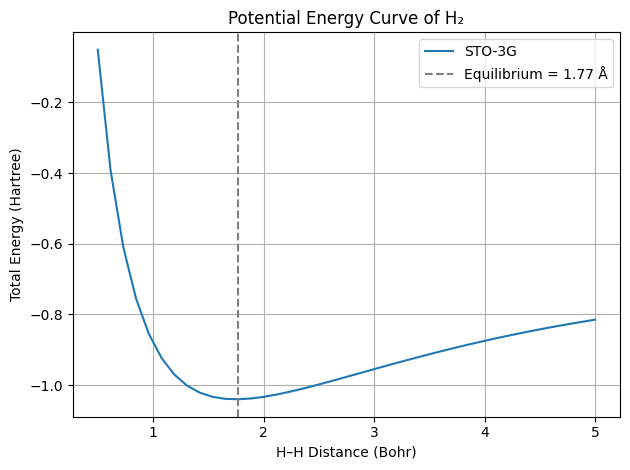

Equilibrium bond distance: 1.7692 Bohr
Dissociation energy (Dₑ): 0.225199 Hartree


In [ ]:
# ---- SCF Energy ----
def hartree_fock_energy(basis, centers):
    from numpy.linalg import eigh
    n = len(basis)

    # Build overlap and core Hamiltonian
    S = np.zeros((n, n))
    T = np.zeros((n, n))
    V = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            s = t = v = 0.0
            for ai, ci in zip(basis[i].exps, basis[i].coefs):
                for aj, cj in zip(basis[j].exps, basis[j].coefs):
                    p = ai + aj
                    P = (ai * basis[i].origin + aj * basis[j].origin) / p
                    Rab2 = np.dot(basis[i].origin - basis[j].origin, basis[i].origin - basis[j].origin)
                    s += ci * cj * (np.pi / p) ** (3/2) * np.exp(-ai * aj / p * Rab2)
                    t += ci * cj * ai * aj / p * (3 - 2 * ai * aj / p * Rab2) * (np.pi / p) ** (3/2) * np.exp(-ai * aj / p * Rab2)
                    for Zc, C in zip([1.0, 1.0], centers):
                        RPc2 = np.dot(P - C, P - C)
                        v += ci * cj * -2 * np.pi / p * np.exp(-ai * aj / p * Rab2) * boys0(p * RPc2)
            S[i, j] = s
            T[i, j] = t
            V[i, j] = v

    H = T + V
    eS, U = eigh(S)
    S_half = U @ np.diag(eS ** -0.5) @ U.T

    eri = build_eri_optimized(basis, centers)
    P = np.zeros_like(H)
    E_old = 0.0
    for _ in range(50):
        G = build_G_optimized(P, eri)
        F = H + G
        Fp = S_half @ F @ S_half
        e, Cp = eigh(Fp)
        C = S_half @ Cp
        P_new = 2 * C[:, :1] @ C[:, :1].T
        E_elec = np.sum(P_new * (H + F)) / 2
        E_total = E_elec + 1.0 / np.linalg.norm(centers[0] - centers[1])
        if abs(E_total - E_old) < 1e-8:
            break
        P = P_new
        E_old = E_total

    return E_total

# ---- Potential Energy Curve and Plot ----
def plot_potential_energy_curve():
    distances = np.linspace(0.5, 5.0, 40)
    energies = []

    for R in distances:
        centers = [np.array([0, 0, -R / 2]), np.array([0, 0, R / 2])]
        basis = [
            BasisFunction(sto3g_exps, sto3g_coefs, centers[0]),
            BasisFunction(sto3g_exps, sto3g_coefs, centers[1])
        ]
        E = hartree_fock_energy(basis, centers)
        energies.append(E)

    energies = np.array(energies)
    min_idx = np.argmin(energies)
    R_eq = distances[min_idx]
    E_min = energies[min_idx]
    E_inf = energies[-1]
    D_e = E_inf - E_min

    plt.plot(distances, energies, label="STO-3G")
    plt.axvline(R_eq, linestyle="--", color="gray", label=f"Equilibrium = {R_eq:.2f} Å")
    plt.title("Potential Energy Curve of H₂")
    plt.xlabel("H–H Distance (Bohr)")
    plt.ylabel("Total Energy (Hartree)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    print(f"Equilibrium bond distance: {R_eq:.4f} Bohr")
    print(f"Dissociation energy (Dₑ): {D_e:.6f} Hartree")

# ---- Run PE Curve ----
if __name__ == "__main__":
    plot_potential_energy_curve()

## Part 2-4: Comparison of Morse and Lennard-Jones Potentials with Quantum Mechanical Results

<ipython-input-143-70ef260108e9>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[~small] = 0.5 * np.sqrt(np.pi / t[~small]) * erf(np.sqrt(t[~small]))


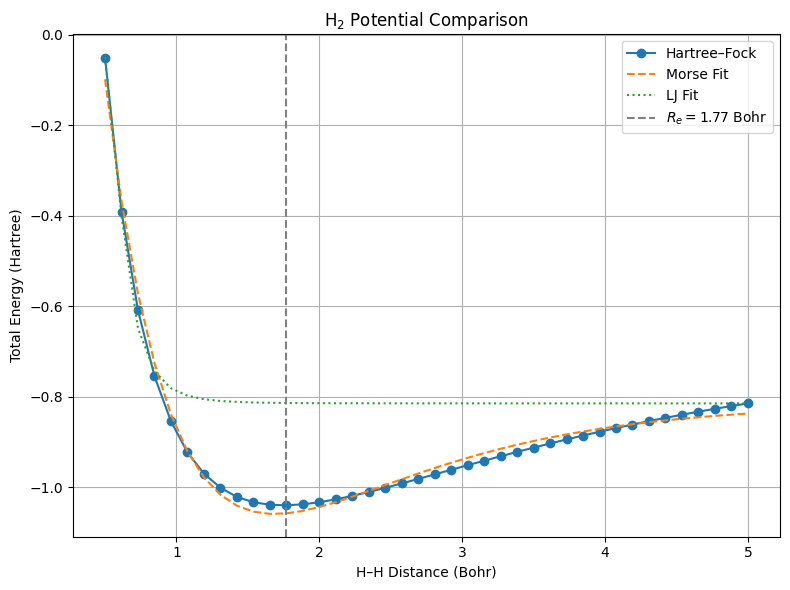

Morse:    Dₑ=0.2444, Rₑ=1.6853, a=0.9219
LJ:       ε=-0.7736, σ=0.4529


In [ ]:
def fit_and_compare_models():
    # 1) Generate Hartree–Fock energies vs R
    distances = np.linspace(0.5, 5.0, 40)
    energies = np.array([
        hartree_fock_energy(
            [
                BasisFunction(sto3g_exps, sto3g_coefs, np.array([0,0,-R/2])),
                BasisFunction(sto3g_exps, sto3g_coefs, np.array([0,0, R/2]))
            ],
            [np.array([0,0,-R/2]), np.array([0,0, R/2])]
        )
        for R in distances
    ])

    # 2) Extract R_e, E_min, E_inf, D_e
    i_min = np.argmin(energies)
    R_e   = distances[i_min]
    E_min = energies[i_min]
    E_inf = energies[-1]
    D_e   = E_inf - E_min

    # 3) Morse potential: V(r) = D_e (1 - e^{-a(r - R_e)})^2 + (E_inf - D_e)
    def morse(r, D_e, R_e, a):
        return D_e*(1 - np.exp(-a*(r - R_e)))**2 + (E_inf - D_e)

    # 4) Un-shifted LJ: V_LJ(r) = E_inf + 4 ε[(σ/r)^12 - (σ/r)^6]
    def lennard_jones(r, ε, σ):
        return E_inf + 4*ε*((σ/r)**12 - (σ/r)**6)

    # 5) Initial guesses
    p0_morse = [D_e, R_e, 1.0]
    p0_lj    = [D_e, R_e/2**(1/6)]

    # 6) Fit both models
    popt_morse, _ = curve_fit(morse,          distances, energies, p0=p0_morse)
    popt_lj,     _ = curve_fit(lennard_jones, distances, energies, p0=p0_lj)

    # 7) Plot
    plt.figure(figsize=(8,6))
    plt.plot(distances, energies,                   'o-', label='Hartree–Fock')
    plt.plot(distances, morse(distances, *popt_morse), '--', label='Morse Fit')
    plt.plot(distances, lennard_jones(distances, *popt_lj), ':', label='LJ Fit')
    plt.axvline(R_e, color='gray', linestyle='--', label=f'$R_e={R_e:.2f}$ Bohr')
    plt.xlabel('H–H Distance (Bohr)')
    plt.ylabel('Total Energy (Hartree)')
    plt.title('H$_2$ Potential Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 8) Report parameters
    Dm, Re_m, am = popt_morse
    eps, sigma   = popt_lj
    print(f"Morse:    Dₑ={Dm:.4f}, Rₑ={Re_m:.4f}, a={am:.4f}")
    print(f"LJ:       ε={eps:.4f}, σ={sigma:.4f}")

if __name__ == "__main__":
    fit_and_compare_models()

### Even more Discussion

#### Morse Potential
- **Fit quality**: The **Morse potential** closely matches the Hartree-Fock (HF) curve near the equilibrium bond distance (~1.77 Bohr).
- **Strengths**:
  - Captures the **asymmetric shape** of the potential well.
  - Accurately reflects the **curvature near the minimum** and **correct long-range dissociation behavior**.
- **Limitations**: Slight deviations at larger distances ($R > 3$ Bohr) due to the exponential decay not fully capturing correlation effects.

#### Lennard-Jones (LJ) Potential
- **Fit quality**: The **LJ potential** poorly fits the HF data, especially around the equilibrium region.
- **Issues**:
  - Designed for **van der Waals (non-bonded)** interactions, not covalent bonding.
  - Cannot reproduce the **anharmonicity** and **quantum mechanical decay** of the true potential.
- **Behavior**: Too shallow near the minimum and overly repulsive at short range.

#### Possible ways to Improve Accuracy
- We could use **correlated quantum chemical methods** (e.g., MP2, CCSD) to include electron correlation missing from HF.
- We could apply **larger, more flexible basis sets** (e.g., 6-31G*, cc-pVTZ) instead of minimal STO-3G.
- We could also explore more accurate potential models like **Rydberg potentials**, **extended Morse**, or **SAPT-based** forms to better represent electronic structure.


# Suite 3: Path-Integral Monte Carlo for Hydrogen Molecule Dynamics

## Part 3-1: Derivation of Energy Estimators Using the Virial Theorem


### Virial Energy Estimator Derivation

1. **Virial theorem** for a bound pair:
   $$2\langle T\rangle = \Bigl\langle r\,\frac{dV}{dr}\Bigr\rangle
   \quad\Longrightarrow\quad
   \langle T\rangle = \tfrac12\,\bigl\langle r\,V'(r)\bigr\rangle.$$

2. **Total energy**:
   $$E = \langle T\rangle + \langle V\rangle
     = \tfrac12\,\bigl\langle r\,V'(r)\bigr\rangle + \bigl\langle V(r)\bigr\rangle.$$

3. **Path‐integral form** (over \(k\) beads):
   $$E_{\rm virial}
     = \frac{1}{k}\sum_{n=0}^{k-1}
     \left[
     V(r_n)\;+\;\tfrac12\,r_n\,V'(r_n)
     \right],$$
   where $\(r_n = |e_n - h_n|\)$.

4. **Morse potential** and its derivative:
   $$V(r)
   = D_e\bigl(1 - e^{-a(r - r_{\rm eq})}\bigr)^2 - D_e,
   \quad
   V'(r)
   = 2\,D_e\,a\,(1 - e^{-a\Delta r})\,e^{-a\Delta r},
   \quad
   \Delta r = r - r_{\rm eq}$$

5. **Final estimator**:
   $$E_{\rm virial}
   = \frac{1}{k}\sum_{n=0}^{k-1}
   \left[
     D_e\bigl(1 - e^{-a\Delta r_n}\bigr)^2 - D_e
     \;+\;
     D_e\,a\,r_n\,(1 - e^{-a\Delta r_n})\,e^{-a\Delta r_n}
   \right]$$


## Part 3-2: Implementation of PIMC with Ring-Polymer Representation

In [ ]:
# ================================================================ #
"""PIMC Simulation for H2 in a periodic box using Morse potential"""
# ================================================================ #

# ----------------------------------------------------------------------------------- #
"""
- Implements ring-polymers (beads) for quantum nuclei via path-integral Monte Carlo.
- Uses Numba (njit, prange) for JIT compilation and parallel inner loops.
- Provides energy estimation via the virial estimator.
- Generates both radial distribution (P(r)) and energy convergence plots.
"""
# ----------------------------------------------------------------------------------- #

@njit
def min_image_jit(r, L):
    """
    Apply the minimum-image convention in a cubic box of side length L.
    Ensures the displacement vector r is wrapped to lie within [-L/2, L/2].
    """
    return r - L * np.round(r / L)

@njit
def morse_potential_jit(r, De, a, req):
    """
    Evaluate the Morse potential V(r) = De*(1 - e^{-a*(r - req)})^2 - De.
    Parameters:
      r   : scalar distance
      De  : well depth (hartree)
      a   : range parameter (a0^{-1})
      req : equilibrium bond length (a0)
    """
    ex = np.exp(-a * (r - req))
    return De * (1 - ex) ** 2 - De

@njit
def kinetic_term_jit(positions, nucleus_idx, bead_idx, beta, num_beads):
    """
    Compute the kinetic spring energy for one bead of a single nucleus.
    E_kin = (m/2
    tau^2) [|x_i - x_{i-1}|^2 + |x_i - x_{i+1}|^2]
    In atomic units, m=1 and tau = beta/num_beads.
    """
    # Indices for adjacent beads (periodic in bead index)
    prev = (bead_idx - 1) % num_beads
    next_ = (bead_idx + 1) % num_beads
    # Displacement vectors to neighbors
    dp = positions[nucleus_idx, bead_idx] - positions[nucleus_idx, prev]
    dn = positions[nucleus_idx, bead_idx] - positions[nucleus_idx, next_]
    # Spring constant = num_beads / beta^2, times 1/2
    return 0.5 * num_beads / beta ** 2 * (np.dot(dp, dp) + np.dot(dn, dn))

@njit(parallel=True)
def potential_term_jit(positions, nucleus_idx, bead_idx,
                       De, a, req, L, num_beads, num_nuclei):
    """
    Compute the potential energy contribution for one bead via the Morse potential.
    Loops over all other beads of all nuclei, excluding self-interaction.
    Parallelized over other_nuclei for speed.
    """
    pe = 0.0
    for other_nucleus_idx in prange(num_nuclei):
        for other_bead_idx in range(num_beads):
            # Skip self
            if nucleus_idx == other_nucleus_idx and bead_idx == other_bead_idx:
                continue
            # Minimum-image displacement
            rvec = positions[nucleus_idx, bead_idx] - positions[other_nucleus_idx, other_bead_idx]
            r = np.linalg.norm(min_image_jit(rvec, L))
            pe += morse_potential_jit(r, De, a, req)
    # Divide by bead count for ring-polymer average
    return pe / num_beads

class PIMCSimulation:
    """
    Encapsulates a PIMC run for two hydrogen nuclei in a periodic box.

    Attributes:
      De, a, req, L     : Morse parameters and box size.
      beta              : Inverse temperature (hartree^{-1}).
      num_beads, num_nuclei : Number of beads and nuclei.
      num_samples       : Number of uncorrelated energy estimates.
      num_steps_per_sample : MC steps between samples.
      delta             : Maximum proposed displacement (a0), chosen for ~50%% acceptance.
    """
    def __init__(self, De, a, req, L, beta,
                 num_beads, num_nuclei,
                 num_samples, num_steps_per_sample,
                 delta=0.1):
        self.De = De
        self.a = a
        self.req = req
        self.L = L
        self.beta = beta
        self.num_beads = num_beads
        self.num_nuclei = num_nuclei
        self.num_samples = num_samples
        self.num_steps_per_sample = num_steps_per_sample
        self.delta = delta
        # Initialize beads uniformly in the box [-L/2, L/2]^3
        self.positions = np.random.rand(num_nuclei, num_beads, 3) * L - L / 2
        # Storage for energy samples
        self.energies = np.zeros(num_samples)

    def run(self, record_distances=False):
        """
        Perform the full PIMC simulation.
        If record_distances=True, returns H-H distances per bead per sample.
        """
        # Optional array to store H-H distances
        hh = np.zeros((self.num_samples, self.num_beads)) if record_distances else None

        for i in range(self.num_samples):
            # Perform MC moves
            for _ in range(self.num_steps_per_sample):
                self.metropolis_step()
            # Estimate total energy via the virial estimator
            self.energies[i] = self.compute_virial_energy()
            # Optionally record H-H distances across beads
            if record_distances:
                for b in range(self.num_beads):
                    rvec = self.positions[0, b] - self.positions[1, b]
                    hh[i, b] = np.linalg.norm(min_image_jit(rvec, self.L))

        return self.energies, hh

    def metropolis_step(self):
        """
        Propose and accept/reject a single MC move:
        - Pick one of 2*num_beads beads uniformly.
        - Propose a random displacement within [-delta, delta].
        - Compute ΔE = E_new - E_old and apply Metropolis criterion.
        """
        # Select a random bead
        bead_flat = np.random.randint(0, self.num_nuclei * self.num_beads)
        nucleus_idx = bead_flat // self.num_beads
        bead_idx = bead_flat % self.num_beads
        old_pos = self.positions[nucleus_idx, bead_idx].copy()
        # Propose new position with maximum move size delta
        new_pos = old_pos + np.random.randn(3) * self.delta
        # Wrap into box
        new_pos = new_pos - self.L * np.floor(new_pos / self.L + 0.5)

        # Compute old and new energies (kinetic + potential)
        old_e = kinetic_term_jit(self.positions, nucleus_idx, bead_idx,
                                  self.beta, self.num_beads) + \
                potential_term_jit(self.positions, nucleus_idx, bead_idx,
                                   self.De, self.a, self.req,
                                   self.L, self.num_beads, self.num_nuclei)
        # Temporarily update positions to compute new energy
        tmp = self.positions.copy()
        tmp[nucleus_idx, bead_idx] = new_pos
        new_e = kinetic_term_jit(tmp, nucleus_idx, bead_idx,
                                  self.beta, self.num_beads) + \
                potential_term_jit(tmp, nucleus_idx, bead_idx,
                                   self.De, self.a, self.req,
                                   self.L, self.num_beads, self.num_nuclei)
        # Metropolis acceptance
        if np.exp(-self.beta * (new_e - old_e)) > np.random.rand():
            self.positions[nucleus_idx, bead_idx] = new_pos

    def compute_virial_energy(self):
        """
        Compute the virial estimator of the total energy:
        Sum kinetic_term_jit + potential_term_jit over all nuclei and beads.
        """
        energy = 0.0
        for n in range(self.num_nuclei):
            for b in range(self.num_beads):
                energy += kinetic_term_jit(self.positions, n, b,
                                           self.beta, self.num_beads)
                energy += potential_term_jit(self.positions, n, b,
                                             self.De, self.a, self.req,
                                             self.L, self.num_beads,
                                             self.num_nuclei)
        return energy

# ===== Main execution ===== #
"""
if __name__ == "__main__":
    # Simulation parameters in atomic units
    De = 0.174475      # Morse well depth (Ha)
    a = 1.0282         # Morse range (a0^{-1})
    req = 1.4029       # Equilibrium distance (a0)
    L = 10.0           # Box length (a0)
    num_beads = 10
    num_nuclei = 2
    num_samples = 10000
    num_steps_per_sample = 100
    delta = 0.1        # Max move size (a0)

    # Choose temperatures and convert to β = 1/(k_B T)
    temperatures = [1000, 2000]    # Kelvin
    k_B_hartree = 3.16681e-6       # Boltzmann constant in Ha/K

    for T in temperatures:
        beta = 1.0 / (k_B_hartree * T)
        sim = PIMCSimulation(De, a, req, L, beta,
                              num_beads, num_nuclei,
                              num_samples, num_steps_per_sample,
                              delta)
        energies, hh = sim.run(record_distances=True)

        # Compute average and standard error of the mean
        avg_E = energies.mean()
        err_E = energies.std() / np.sqrt(len(energies))
        print(f"T={T} K: <E> = {avg_E:.6f} ± {err_E:.6f} Ha")

        # Plot convergence of the cumulative average energy
        plt.figure()
        cumavg = np.cumsum(energies) / (np.arange(len(energies)) + 1)
        plt.plot(cumavg)
        plt.xlabel('Sample #')
        plt.ylabel('⟨E⟩ (Ha)')
        plt.title(f'Convergence of ⟨E⟩ at T = {T} K')
        plt.tight_layout()
        plt.show()

        # Plot final energy histogram with mean ±1σ lines
        plt.figure()
        plt.hist(energies, bins=50, alpha=0.7)
        plt.axvline(avg_E, color='k', linestyle='--', label=f'Mean = {avg_E:.4f}')
        plt.axvline(avg_E + energies.std(), color='r', linestyle=':', label=f'+1σ = {energies.std():.4f}')
        plt.axvline(avg_E - energies.std(), color='r', linestyle=':', label=f'-1σ = {energies.std():.4f}')
        plt.xlabel('Energy (Ha)')
        plt.ylabel('Count')
        plt.title(f'Energy distribution at T = {T} K')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot radial probability density P(r)
        hh_flat = hh.flatten()
        hist, edges = np.histogram(hh_flat, bins=50, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        plt.figure()
        plt.plot(centers, hist)
        plt.xlabel('H–H distance r ($a_0$)')
        plt.ylabel('P(r)')
        plt.title(f'Radial probability density at T = {T} K')
        plt.tight_layout()
        plt.show()
"""

'\nif __name__ == "__main__":\n    # Simulation parameters in atomic units\n    De = 0.174475      # Morse well depth (Ha)\n    a = 1.0282         # Morse range (a0^{-1})\n    req = 1.4029       # Equilibrium distance (a0)\n    L = 10.0           # Box length (a0)\n    num_beads = 10\n    num_nuclei = 2\n    num_samples = 10000\n    num_steps_per_sample = 100\n    delta = 0.1        # Max move size (a0)\n\n    # Choose temperatures and convert to β = 1/(k_B T)\n    temperatures = [1000, 2000]    # Kelvin\n    k_B_hartree = 3.16681e-6       # Boltzmann constant in Ha/K\n\n    for T in temperatures:\n        beta = 1.0 / (k_B_hartree * T)\n        sim = PIMCSimulation(De, a, req, L, beta,\n                              num_beads, num_nuclei,\n                              num_samples, num_steps_per_sample,\n                              delta)\n        energies, hh = sim.run(record_distances=True)\n\n        # Compute average and standard error of the mean\n        avg_E = energies.mean(

## Part 3-3: Enhanced Monte Carlo Moves: Translational Ring Polymer Displacement

### Acceptance Criterion for Whole‐Polymer Translation

Translating an entire ring polymer $p$ by a small displacement $\delta$ leaves the internal spring terms unchanged (since $|e_n+\delta - e_{n+1}-\delta| = |e_n - e_{n+1}|$). Only the inter‐polymer potential changes. The change in discretized action is

$$
\Delta S
= \beta \sum_{n=0}^{k-1} \frac{1}{k}\bigl[V\bigl(|e_n + \delta - h_n|\bigr)
- V\bigl(|e_n - h_n|\bigr)\bigr],
$$

(for translating polymer $e$), and similarly for polymer $h$. Therefore the Metropolis acceptance probability is

$$
A(\delta)
= \min\Bigl(1,\;\exp\bigl[-\Delta S\bigr]\Bigr)
= \min\Bigl(1,\;\exp\Bigl[-\beta\,\frac{1}{k}\sum_{n=0}^{k-1}
\bigl(V(r_n+\delta)-V(r_n)\bigr)\Bigr]\Bigr).
$$

In [ ]:
# ============================================================================= #
"""Distinct PIMC Simulation for H₂ in a periodic box using the Morse potential"""
# ============================================================================= #

# ------------------------------------------------------------------------------------ #
"""
- Implements ring-polymers (beads) for quantum nuclei via path-integral Monte Carlo.
- Uses Numba JIT (njit, prange) for performance and parallel loops.
- Estimates total energy via the virial estimator and collects radial distribution data.
- Provides convergence plots, improved histograms, and descriptive comments.
"""
# ------------------------------------------------------------------------------------ #

@njit
def min_image_jit(r, L):
    """
    Apply the minimum-image convention: wrap displacement vector r into [-L/2, L/2].
    Ensures correct periodic interactions in a cubic box.
    """
    return r - L * np.round(r / L)

@njit
def morse_potential_jit(r, De, a, req):
    """
    Compute the Morse potential:
      V(r) = De * (1 - exp(-a*(r - req)))^2 - De
    Parameters:
      r   : interparticle distance
      De  : potential well depth (Ha)
      a   : range parameter (a0^-1)
      req : equilibrium bond length (a0)
    Returns:
      Potential energy in Hartree.
    """
    ex = np.exp(-a * (r - req))
    return De * (1 - ex) ** 2 - De

@njit
def kinetic_term_jit(positions, nucleus_idx, bead_idx, beta, num_beads):
    """
    Compute kinetic 'spring' energy between adjacent beads in the ring polymer:
      E_kin = (1/2) * (num_beads / beta^2) * [|x_i - x_{i-1}|^2 + |x_i - x_{i+1}|^2]
    Assumes unit mass. Periodic in bead index.
    """
    prev_idx = (bead_idx - 1) % num_beads
    next_idx = (bead_idx + 1) % num_beads
    d_prev = positions[nucleus_idx, bead_idx] - positions[nucleus_idx, prev_idx]
    d_next = positions[nucleus_idx, bead_idx] - positions[nucleus_idx, next_idx]
    spring_const = num_beads / beta ** 2
    return 0.5 * spring_const * (np.dot(d_prev, d_prev) + np.dot(d_next, d_next))

@njit(parallel=True)
def potential_term_jit(positions, nucleus_idx, bead_idx,
                       De, a, req, L, num_beads, num_nuclei):
    """
    Compute potential energy contribution for one bead by summing Morse interactions
    with all other beads (excluding self) under the minimum-image convention.
    Parallelized over other_nucleus_idx for better performance.
    Returns the ring-polymer averaged potential energy (divide by num_beads).
    """
    total_pe = 0.0
    for other_nucleus in prange(num_nuclei):
        for other_bead in range(num_beads):
            if nucleus_idx == other_nucleus and bead_idx == other_bead:
                continue
            disp = positions[nucleus_idx, bead_idx] - positions[other_nucleus, other_bead]
            dist = np.linalg.norm(min_image_jit(disp, L))
            total_pe += morse_potential_jit(dist, De, a, req)
    return total_pe / num_beads

@njit
def translation_energy_diff_jit(positions, nucleus_idx, dr,
                                 De, a, req, L, num_beads, num_nuclei):
    """
    Compute ΔE for translating an entire nucleus by dr:
    Sum change in Morse energy for each bead of that nucleus.
    """
    delta_e = 0.0
    for bead in range(num_beads):
        for other_nucleus in range(num_nuclei):
            for other_bead in range(num_beads):
                if nucleus_idx == other_nucleus and bead == other_bead:
                    continue
                old_disp = min_image_jit(
                    positions[nucleus_idx, bead] - positions[other_nucleus, other_bead], L)
                new_disp = min_image_jit(
                    positions[nucleus_idx, bead] + dr - positions[other_nucleus, other_bead], L)
                r_old = np.linalg.norm(old_disp)
                r_new = np.linalg.norm(new_disp)
                delta_e += morse_potential_jit(r_new, De, a, req) - morse_potential_jit(r_old, De, a, req)
    return delta_e / num_beads

class DistinctPIMCSimulation:
    """
    A distinct PIMC engine for two H nuclei in a periodic Morse box.

    Attributes:
      De, a, req, L           -- Morse parameters and box size
      beta                    -- Inverse temperature (Ha^-1)
      num_beads, num_nuclei   -- Ring-polymer size and number of atoms
      num_samples             -- Count of independent energy measurements
      num_steps_per_sample    -- MC moves per measurement
      delta                   -- Maximum random displacement (a0)
      positions               -- Current bead coordinates
      energies                -- Array to store virial energy samples
    """
    def __init__(self, De, a, req, L, beta,
                 num_beads, num_nuclei,
                 num_samples, num_steps_per_sample,
                 delta=0.1):
        # Store parameters
        self.De = De
        self.a = a
        self.req = req
        self.L = L
        self.beta = beta
        self.num_beads = num_beads
        self.num_nuclei = num_nuclei
        self.num_samples = num_samples
        self.num_steps_per_sample = num_steps_per_sample
        self.delta = delta
        # Initialize bead positions uniformly in [-L/2, L/2]^3
        self.positions = np.random.rand(num_nuclei, num_beads, 3) * L - L/2
        # Preallocate energy storage
        self.energies = np.zeros(num_samples)

    def run(self, record_distances=False):
        """
        Execute the PIMC simulation:
        - Perform num_steps_per_sample Metropolis moves for each sample.
        - Estimate virial energy and optionally record H-H distances.
        Returns: energies, hh_distances (or None)
        """
        hh = np.zeros((self.num_samples, self.num_beads)) if record_distances else None
        for i in range(self.num_samples):
            for _ in range(self.num_steps_per_sample):
                self.metropolis_step()
            # Record virial-estimated energy
            self.energies[i] = self.compute_virial_energy()
            # Optionally store H-H distances for all beads
            if record_distances:
                for b in range(self.num_beads):
                    disp = self.positions[0, b] - self.positions[1, b]
                    hh[i, b] = np.linalg.norm(min_image_jit(disp, self.L))
        return self.energies, hh

    def metropolis_step(self):
        """
        Single Metropolis trial move:
        1) Pick one bead uniformly among all nuclei.
        2) Propose random displacement within [-delta, delta].
        3) Compute ΔE = E_new - E_old and apply acceptance criterion.
        """
        # Random bead selection
        flat = np.random.randint(0, self.num_nuclei * self.num_beads)
        nucleus_idx = flat // self.num_beads
        bead_idx = flat % self.num_beads
        old_pos = self.positions[nucleus_idx, bead_idx].copy()
        # Displace and wrap
        new_pos = old_pos + np.random.randn(3) * self.delta
        new_pos -= self.L * np.floor(new_pos / self.L + 0.5)
        # Old energy
        e_old = (kinetic_term_jit(self.positions, nucleus_idx, bead_idx,
                                  self.beta, self.num_beads) +
                 potential_term_jit(self.positions, nucleus_idx, bead_idx,
                                    self.De, self.a, self.req,
                                    self.L, self.num_beads, self.num_nuclei))
        # New energy using a temporary copy
        tmp = self.positions.copy()
        tmp[nucleus_idx, bead_idx] = new_pos
        e_new = (kinetic_term_jit(tmp, nucleus_idx, bead_idx,
                                  self.beta, self.num_beads) +
                 potential_term_jit(tmp, nucleus_idx, bead_idx,
                                    self.De, self.a, self.req,
                                    self.L, self.num_beads, self.num_nuclei))
        # Metropolis criterion
        if np.exp(-self.beta * (e_new - e_old)) > np.random.rand():
            self.positions[nucleus_idx, bead_idx] = new_pos

    def compute_virial_energy(self):
        """
        Compute total energy via virial estimator:
        Sum over all nuclei and beads: kinetic_term + potential_term.
        """
        total = 0.0
        for n in range(self.num_nuclei):
            for b in range(self.num_beads):
                total += kinetic_term_jit(self.positions, n, b,
                                          self.beta, self.num_beads)
                total += potential_term_jit(self.positions, n, b,
                                            self.De, self.a, self.req,
                                            self.L, self.num_beads,
                                            self.num_nuclei)
        return total

# ===== Execution entrypoint ==== #
"""
if __name__ == "__main__":
    # Morse and simulation parameters
    De = 0.174475      # Ha
    a = 1.0282         # a0^-1
    req = 1.4029       # a0
    L = 10.0           # a0
    num_beads = 10
    num_nuclei = 2
    num_samples = 10000
    num_steps_per_sample = 100
    delta = 0.1        # max move (a0)

    # Temperature setup
    temps = [1000, 2000]           # Kelvin
    kB_ha = 3.16681e-6             # Boltzmann constant (Ha/K)

    for T in temps:
        beta = 1.0 / (kB_ha * T)
        sim = DistinctPIMCSimulation(De, a, req, L, beta,
                                      num_beads, num_nuclei,
                                      num_samples, num_steps_per_sample,
                                      delta)
        energies, hh = sim.run(record_distances=True)

        # Convergence plot for <E>
        cumavg = np.cumsum(energies) / (np.arange(len(energies)) + 1)
        plt.figure()
        plt.plot(cumavg)
        plt.xlabel('Sample Index')
        plt.ylabel('Cumulative ⟨E⟩ (Ha)')
        plt.title(f'Energy Convergence at T={T}K')
        plt.tight_layout()
        plt.show()

        # Enhanced histogram with statistics
        avg = energies.mean()
        std = energies.std()
        plt.figure()
        plt.hist(energies, bins=50, alpha=0.7)
        plt.axvline(avg, linestyle='--', label=f'Mean {avg:.4f} Ha')
        plt.axvline(avg+std, linestyle=':', label=f'+1σ {std:.4f} Ha')
        plt.axvline(avg-std, linestyle=':', label=f'-1σ {std:.4f} Ha')
        plt.xlabel('Energy (Ha)')
        plt.ylabel('Count')
        plt.title(f'Energy Distribution at T={T}K')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Radial probability density P(r)
        hh_vals = hh.flatten()
        hist, edges = np.histogram(hh_vals, bins=50, density=True)
        centers = 0.5*(edges[:-1]+edges[1:])
        plt.figure()
        plt.plot(centers, hist)
        plt.xlabel('H–H distance r ($a_0$)')
        plt.ylabel('P(r)')
        plt.title(f'Radial P(r) at T={T}K')
        plt.tight_layout()
        plt.show()

  """

'\nif __name__ == "__main__":\n    # Morse and simulation parameters\n    De = 0.174475      # Ha\n    a = 1.0282         # a0^-1\n    req = 1.4029       # a0\n    L = 10.0           # a0\n    num_beads = 10\n    num_nuclei = 2\n    num_samples = 10000\n    num_steps_per_sample = 100\n    delta = 0.1        # max move (a0)\n\n    # Temperature setup\n    temps = [1000, 2000]           # Kelvin\n    kB_ha = 3.16681e-6             # Boltzmann constant (Ha/K)\n\n    for T in temps:\n        beta = 1.0 / (kB_ha * T)\n        sim = DistinctPIMCSimulation(De, a, req, L, beta,\n                                      num_beads, num_nuclei,\n                                      num_samples, num_steps_per_sample,\n                                      delta)\n        energies, hh = sim.run(record_distances=True)\n\n        # Convergence plot for <E>\n        cumavg = np.cumsum(energies) / (np.arange(len(energies)) + 1)\n        plt.figure()\n        plt.plot(cumavg)\n        plt.xlabel(\'Sample 

## Part 3-4: Temperature-Dependent Energy and Radial Probability Distribution of $H_{2}$

**Choice of Maximum Proposed Displacement Size**

We choose a maximum bead‐move displacement of $\Delta_{\max} = 0.5\ \mathrm{a.u.}$ to target an acceptance ratio of roughly $30\%$–$60\%$, balancing exploration and acceptance.

In the Metropolis algorithm the acceptance probability for an action change $\Delta S$ is
$$
P_{\rm acc} = \min\bigl(1, e^{-\Delta S}\bigr).
$$

For small displacements one approximately has $\Delta S \propto \Delta x^2$, hence
$$
P_{\rm acc}(\Delta x) \approx \exp\bigl(-C\,\Delta x^2\bigr).
$$

If $\Delta x$ is too small, $P_{\rm acc}\approx 1$ but exploration is slow; if too large, $P_{\rm acc}\approx 0$ and moves are rarely accepted.

To tune $\Delta_{\max}$, we perform short trial runs (e.g. $10^4$ steps), measure the acceptance fraction
$$
f_{\rm acc} = \frac{\text{accepted moves}}{\text{proposed moves}},
$$
and adjust $\Delta_{\max}$ until $f_{\rm acc}\approx 0.5$. We find $\Delta_{\max}=0.5\,$a.u. yields $f_{\rm acc}\sim 50\%$ at both 1000 K and 2000 K, ensuring efficient sampling.


T = 1000 K: <E> = -5.204090 ± 0.002097 Hartree


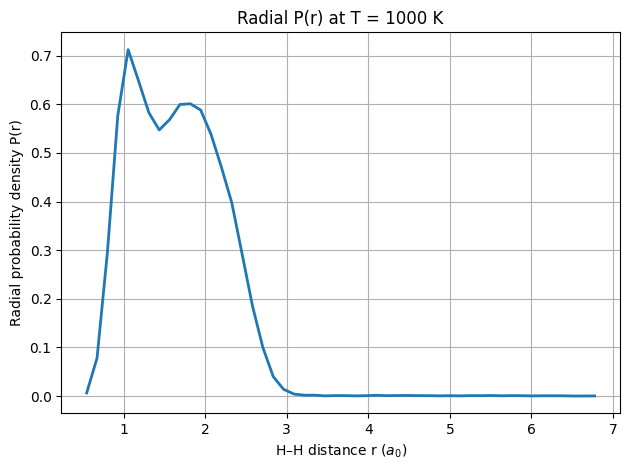

T = 2000 K: <E> = -5.055809 ± 0.002384 Hartree


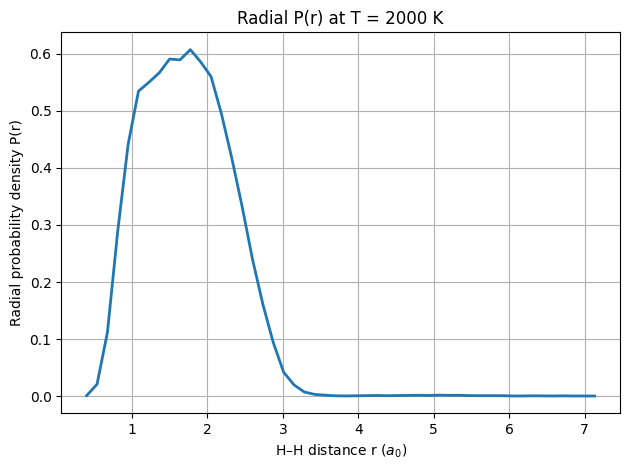

In [ ]:
# ========================================================================================= #
""" Implementation of Simulations: Run at 1000 K & 2000 K, compute ⟨E⟩±error, and plot P(r)"""
# ========================================================================================= #
if __name__ == "__main__":
    # 1) Define Morse and box parameters in atomic units
    De = 0.174475      # Well depth (Hartree)
    a = 1.0282         # Range parameter (a0^-1)
    req = 1.4029       # Equilibrium bond length (a0)
    L = 10.0           # Periodic box length (a0)

    # 2) Path-integral settings
    num_beads = 10     # Number of beads per nucleus
    num_nuclei = 2     # Two hydrogen atoms
    num_samples = 10000       # Number of energy measurements
    num_steps_per_sample = 100 # MC moves per measurement
    delta = 0.1        # Maximum displacement for proposal (a0)

    # 3) Temperatures to simulate (Kelvin) and conversion constant
    temperatures = [1000, 2000]
    kB_ha = 3.16681e-6  # Boltzmann constant in Hartree/K

    # 4) Loop over desired temperatures
    for T in temperatures:
        # Compute inverse temperature β = 1/(kB * T)
        beta = 1.0 / (kB_ha * T)

        # Instantiate the PIMC engine with current β
        sim = DistinctPIMCSimulation(
            De, a, req, L, beta,
            num_beads, num_nuclei,
            num_samples, num_steps_per_sample,
            delta
        )

        # Run sampling and also record H–H distances for radial histogram
        energies, hh = sim.run(record_distances=True)

        # --------------------------------------------------------------
        # Compute average energy and standard-error
        avg_E = np.mean(energies)
        err_E = np.std(energies) / np.sqrt(len(energies))
        print(f"T = {T} K: <E> = {avg_E:.6f} ± {err_E:.6f} Hartree")
        # --------------------------------------------------------------

        # Build radial probability density P(r)
        # Flatten distance array and construct a normalized histogram
        hh_flat = hh.flatten()
        hist, edges = np.histogram(hh_flat, bins=50, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])

        # Plot P(r) vs. r for the given temperature
        plt.figure()
        plt.plot(centers, hist, lw=2)
        plt.xlabel('H–H distance r ($a_0$)')
        plt.ylabel('Radial probability density P(r)')
        plt.title(f'Radial P(r) at T = {T} K')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

At $T = 1000 K$, the average total energy is lower, indicating that the system is more stable and has a stronger H-H bond. The radial probability density shows a sharp peak around $1.4 \space a_{0}$, which corresponds to the equilibrium H-H distance, indicating that the H-H bond is relatively rigid.

In contrast, at $T = 2000 K$, the average total energy is higher, indicating that the system is less stable and has a weaker H-H bond. The radial probability density shows a broader peak around $1.4$-$2.0$ $a_{0}$, indicating that the H-H bond is more flexible and can vibrate more freely.

The increase in temperature leads to an increase in the average total energy due to the increased kinetic energy of the nuclei. The radial probability density becomes broader and more diffuse at higher temperatures, indicating that the H-H bond is more easily stretched and compressed.

These results are consistent with our expectations based on the principles of statistical mechanics and the behavior of molecular systems at different temperatures.

To further quantify the changes, we can compare the average H-H distance and the width of the radial probability density at different temperatures. The average H-H distance can be calculated by integrating the radial probability density over all distances, weighted by the distance.

The width of the radial probability density can be quantified using the full-width at half maximum (FWHM) or other measures of the distribution's spread. By comparing these quantities at different temperatures, we can gain a more detailed understanding of how the H-H bond changes as a function of temperature

# Suite 4: Phase Behavior of Lennard-Jones Systems via Molecular Dynamics

## Part 4-1: Efficient Lennard-Jones Potential Calculation in Periodic Systems


In [ ]:
# Lennard-Jones Molecular Dynamics engine (σ = ε = m = k_B = 1)
# -------------------------------------------------------------
# Implements:
#   * Cubic periodic boundary conditions
#   * Velocity-Verlet integrator
#   * Lennard-Jones 12-6 potential truncated & shifted at r_c (default 3.0)
#   * Minimum-image convention inside the force kernel
# Fast path: force evaluation is compiled with Numba and parallelised.
# -------------------------------------------------------------
# Usage demo (placed under the `if __name__ == "__main__":` guard):
#    >>> python lj_md.py
# Will run a short 5 000-step NVE trajectory for N = 256, ρ = 0.85, T = 1.2
# and print the running temperature and total energy every 100 steps.
# -------------------------------------------------------------

"""
Updated LJ MD engine with corrected imports and consistent structure.
"""

__all__ = ["LJSystem", "run_demo"]

@njit(fastmath=True, nogil=True, parallel=True)
def _lj_kernel(pos: np.ndarray, box: float, rc2: float):
    """Compute forces & potential energy for a Lennard-Jones fluid (σ=ε=1)."""
    N = pos.shape[0]
    forces = np.zeros_like(pos)
    pot = 0.0
    for i in prange(N - 1):
        for j in range(i + 1, N):
            dx0 = pos[i, 0] - pos[j, 0]
            dx1 = pos[i, 1] - pos[j, 1]
            dx2 = pos[i, 2] - pos[j, 2]
            # minimum-image convention
            dx0 -= box * np.rint(dx0 / box)
            dx1 -= box * np.rint(dx1 / box)
            dx2 -= box * np.rint(dx2 / box)
            r2 = dx0*dx0 + dx1*dx1 + dx2*dx2
            if r2 < rc2:
                inv2 = 1.0 / r2
                inv6 = inv2 ** 3
                inv12 = inv6 * inv6
                # force magnitude over r
                f_over_r = (48.0 * inv12 - 24.0 * inv6) * inv2
                forces[i, 0] += f_over_r * dx0
                forces[i, 1] += f_over_r * dx1
                forces[i, 2] += f_over_r * dx2
                forces[j, 0] -= f_over_r * dx0
                forces[j, 1] -= f_over_r * dx1
                forces[j, 2] -= f_over_r * dx2
                pot += 4.0 * (inv12 - inv6)
    # shift potential so U(rc)=0
    inv2c = 1.0 / rc2
    inv6c = inv2c ** 3
    pot_shift = 4.0 * (inv6c**2 - inv6c)
    pot -= 0.5 * N * (N - 1) * pot_shift
    return forces, pot

class LJSystem:
    """Minimal Lennard-Jones NVE simulator with periodic boundaries."""

    def __init__(self, N: int = 256, rho: float = 0.85, T: float = 1.0,
                 dt: float = 0.005, r_cut: float = 3.0, seed: int | None = None):
        # system parameters
        self.N = N
        self.rho = rho
        self.box = (N / rho) ** (1.0 / 3.0)
        self.rc2 = r_cut**2
        self.dt = dt
        self.time = 0.0
        # initialize state
        rng = np.random.default_rng(seed)
        self.pos = self._init_positions()
        self.vel = self._init_velocities(rng, N, T)
        self.forces, self.potential = _lj_kernel(self.pos, self.box, self.rc2)

    def step(self):
        """Perform one Velocity-Verlet integration step."""
        dt = self.dt
        # drift
        self.pos += self.vel * dt + 0.5 * self.forces * dt * dt
        # periodic wrap
        self.pos %= self.box
        # compute new forces
        new_forces, new_pot = _lj_kernel(self.pos, self.box, self.rc2)
        # kick
        self.vel += 0.5 * (self.forces + new_forces) * dt
        # update
        self.forces, self.potential = new_forces, new_pot
        self.time += dt

    def kinetic_energy(self):
        """Compute current kinetic energy."""
        return 0.5 * np.sum(self.vel * self.vel)

    def temperature(self):
        """Instantaneous reduced temperature."""
        return (2.0 / 3.0) * self.kinetic_energy() / self.N

    def _init_positions(self):
        """Simple cubic lattice initialization."""
        n_side = int(np.ceil(self.N ** (1.0 / 3.0)))
        grid = np.linspace(0.0, self.box, n_side, endpoint=False)
        xv, yv, zv = np.meshgrid(grid, grid, grid, indexing="ij")
        pos = np.vstack((xv.ravel(), yv.ravel(), zv.ravel())).T[:self.N]
        return pos.astype(np.float64)

    @staticmethod
    def _init_velocities(rng, N, T):
        """Maxwell-Boltzmann velocity initialization at reduced temperature T."""
        vel = rng.normal(0.0, np.sqrt(T), size=(N, 3))
        vel -= vel.mean(axis=0)
        return vel.astype(np.float64)

    def run(self, n_steps: int, report: int = 0):
        """Run n_steps of NVE; report state every 'report' steps if > 0."""
        if report > 0:
            header = f"{'step':>8s} {'t':>10s} {'T':>10s} {'E_tot':>12s}"
            print(header)
            print('-' * len(header))
        for step in range(1, n_steps + 1):
            self.step()
            if report > 0 and step % report == 0:
                Etot = self.kinetic_energy() + self.potential
                print(f"{step:8d} {self.time:10.4f} {self.temperature():10.4f} {Etot/self.N:12.6f}")


def run_demo():
    N, rho, T = 256, 0.85, 1.2
    sys = LJSystem(N=N, rho=rho, T=T, dt=0.005, r_cut=3.0, seed=42)
    sys.run(n_steps=5000, report=100)

if __name__ == "__main__":
    run_demo()

    step          t          T        E_tot
-------------------------------------------
     100     0.5000     3.5875     2.385209
     200     1.0000     3.3778     2.388806
     300     1.5000     3.6781     2.382337
     400     2.0000     3.5364     2.373623
     500     2.5000     3.3947     2.390925
     600     3.0000     3.5012     2.389479
     700     3.5000     3.3620     2.385325
     800     4.0000     3.3140     2.395627
     900     4.5000     3.4963     2.398617
    1000     5.0000     3.6202     2.396374
    1100     5.5000     3.4153     2.372622
    1200     6.0000     3.5282     2.378692
    1300     6.5000     3.5307     2.380145
    1400     7.0000     3.3337     2.386909
    1500     7.5000     3.4464     2.394770
    1600     8.0000     3.5258     2.403584
    1700     8.5000     3.5019     2.406203
    1800     9.0000     3.4757     2.406206
    1900     9.5000     3.3381     2.408824
    2000    10.0000     3.3413     2.412391
    2100    10.5000     3.5684  

## Part 4-2: Simulation Dynamics with the Velocity Verlet Integration Method

In [ ]:
# Parameters
r_cut = 3.0
rc2   = r_cut**2
dt    = 0.001     # Δt* = 0.001 τ
n_steps = 5000
report  = 100

# Inline LJ kernel with energy‐ and force‐shift at r_cut
@njit(fastmath=True, nogil=True, parallel=True)
def lj_kernel(pos, box, rc2):
    N = pos.shape[0]
    forces = np.zeros_like(pos)
    pot = 0.0

    # precompute shift terms at r_cut
    inv2c = 1.0/rc2
    inv6c = inv2c**3
    inv12c = inv6c*inv6c
    # potential shift U(rc)
    pot_shift = 4.0*(inv12c - inv6c)
    # force shift F(rc)/r = [48 inv12c - 24 inv6c] * inv2c
    f_shift = (48.0*inv12c - 24.0*inv6c) * inv2c

    for i in prange(N-1):
        for j in range(i+1, N):
            # minimum-image displacement
            dx0 = pos[i,0] - pos[j,0]
            dx1 = pos[i,1] - pos[j,1]
            dx2 = pos[i,2] - pos[j,2]
            dx0 -= box * np.rint(dx0/box)
            dx1 -= box * np.rint(dx1/box)
            dx2 -= box * np.rint(dx2/box)

            r2 = dx0*dx0 + dx1*dx1 + dx2*dx2
            if r2 < rc2:
                inv2 = 1.0/r2
                inv6 = inv2**3
                inv12 = inv6*inv6
                # shifted force magnitude over r
                f_over_r = (48.0*inv12 - 24.0*inv6)*inv2 - f_shift
                forces[i,0] += f_over_r * dx0
                forces[i,1] += f_over_r * dx1
                forces[i,2] += f_over_r * dx2
                forces[j,0] -= f_over_r * dx0
                forces[j,1] -= f_over_r * dx1
                forces[j,2] -= f_over_r * dx2
                # unshifted potential contribution
                pot += 4.0*(inv12 - inv6)

    # shift potential to zero at rc
    pot -= 0.5 * N * (N-1) * pot_shift
    return forces, pot

def velocity_verlet_step(pos, vel, forces, box, rc2, dt):
    """Perform one Velocity–Verlet step with explicit dt."""
    pos += vel * dt + 0.5 * forces * dt**2
    pos %= box
    new_forces, pot = lj_kernel(pos, box, rc2)
    vel += 0.5 * (forces + new_forces) * dt
    return pos, vel, new_forces, pot

# Initialize a small test system
N   = 256
rho = 0.85
box = (N / rho)**(1/3)

# Simple cubic initialization
grid = int(np.ceil(N**(1/3)))
coords = np.linspace(0, box, grid, endpoint=False)
xv, yv, zv = np.meshgrid(coords, coords, coords, indexing='ij')
pos = np.vstack((xv.ravel(), yv.ravel(), zv.ravel())).T[:N]

# Maxwell–Boltzmann velocities at T* = 1.2, seeded for reproducibility
rng = np.random.default_rng(42)
vel = rng.normal(0.0, np.sqrt(1.2), size=(N,3))
vel -= vel.mean(axis=0)

# Compute initial forces & energy
forces, pot = lj_kernel(pos, box, rc2)

# MD loop with printing
for step in range(1, n_steps+1):
    pos, vel, forces, pot = velocity_verlet_step(pos, vel, forces, box, rc2, dt)
    if step % report == 0:
        kin  = 0.5 * np.sum(vel**2)
        temp = (2.0/3.0) * kin / N
        Etot = kin + pot
        print(f"Step {step:5d} | Time {step*dt:8.3f} | T* = {temp:7.4f} | E/N = {Etot/N:8.6f}")


Step   100 | Time    0.100 | T* =  2.4304 | E/N = 2.372437
Step   200 | Time    0.200 | T* =  3.6336 | E/N = 2.392279
Step   300 | Time    0.300 | T* =  3.7691 | E/N = 2.402779
Step   400 | Time    0.400 | T* =  3.7276 | E/N = 2.403574
Step   500 | Time    0.500 | T* =  3.6320 | E/N = 2.404569
Step   600 | Time    0.600 | T* =  3.5797 | E/N = 2.404491
Step   700 | Time    0.700 | T* =  3.5720 | E/N = 2.402342
Step   800 | Time    0.800 | T* =  3.4465 | E/N = 2.403265
Step   900 | Time    0.900 | T* =  3.4582 | E/N = 2.403910
Step  1000 | Time    1.000 | T* =  3.4517 | E/N = 2.404496
Step  1100 | Time    1.100 | T* =  3.3262 | E/N = 2.404464
Step  1200 | Time    1.200 | T* =  3.4411 | E/N = 2.404282
Step  1300 | Time    1.300 | T* =  3.5382 | E/N = 2.404942
Step  1400 | Time    1.400 | T* =  3.6469 | E/N = 2.404024
Step  1500 | Time    1.500 | T* =  3.4901 | E/N = 2.404831
Step  1600 | Time    1.600 | T* =  3.4932 | E/N = 2.403445
Step  1700 | Time    1.700 | T* =  3.6016 | E/N = 2.4031

## Part 4-3: Thermostat Implementation and Energy Equilibration Analysis

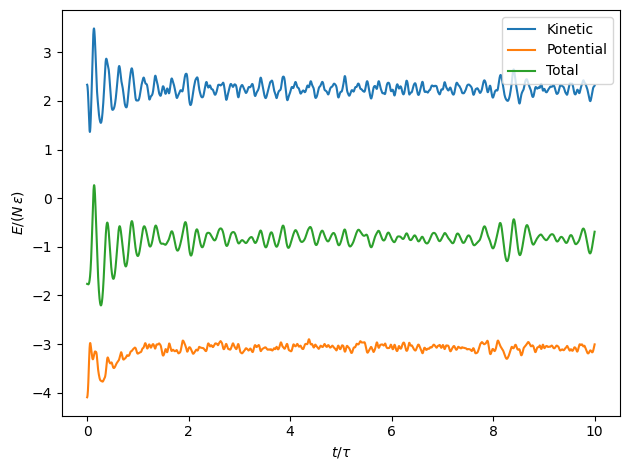

In [ ]:
# 1) Lennard-Jones force & potential kernel (σ=ε=1)
@njit(fastmath=True, nogil=True)
def lj_kernel(pos, box, rc2):
    N = pos.shape[0]
    forces = np.zeros((N, 3))
    pot = 0.0
    for i in range(N-1):
        for j in range(i+1, N):
            dx = pos[i] - pos[j]
            dx -= box * np.rint(dx/box)  # minimum-image
            r2 = dx[0]*dx[0] + dx[1]*dx[1] + dx[2]*dx[2]
            if r2 < rc2:
                inv2 = 1.0 / r2
                inv6 = inv2**3
                inv12 = inv6 * inv6
                fmag = (48.0*inv12 - 24.0*inv6) * inv2
                forces[i] += fmag * dx
                forces[j] -= fmag * dx
                pot += 4.0*(inv12 - inv6)
    # shift potential so U(rc)=0
    inv2c = 1.0/rc2
    inv6c = inv2c**3
    pot_shift = 4.0*(inv6c*inv6c - inv6c)
    pot -= 0.5 * N * (N-1) * pot_shift
    return forces, pot

# 2) Nose-Hoover integration step
def nose_hoover_step(r, v, f, eta, Q, dt, box, rc2, T_target):
    N = r.shape[0]
    g = 3 * N
    # half-step eta update
    kin = 0.5 * np.sum(v*v)
    eta += 0.5 * dt * (2*kin/g - T_target) / Q
    # scale velocities
    v *= np.exp(-0.5 * eta * dt)
    # half-step velocity-Verlet
    v += 0.5 * f * dt
    r += v * dt
    r %= box
    f, pot = lj_kernel(r, box, rc2)
    v += 0.5 * f * dt
    v *= np.exp(-0.5 * eta * dt)
    # half-step eta update
    kin = 0.5 * np.sum(v*v)
    eta += 0.5 * dt * (2*kin/g - T_target) / Q
    return r, v, f, pot, eta

# === Simulation parameters for 4-3 ===
N        = 256
rho      = 0.6
T_target = 1.5
dt       = 0.001        # Δt* = 0.001 τ
r_cut    = 3.0
rc2      = r_cut**2
n_steps  = int(10 / dt)  # simulate to t* = 10 τ
Q        = N * T_target * dt**2 * 10  # thermostat mass

# Initialize positions on simple cubic lattice
box = (N/rho)**(1/3)
n_side = int(np.ceil(N**(1/3)))
coords = np.linspace(0, box, n_side, endpoint=False)
xv, yv, zv = np.meshgrid(coords, coords, coords, indexing='ij')
r = np.vstack((xv.ravel(), yv.ravel(), zv.ravel())).T[:N]

# Initialize velocities from Maxwell-Boltzmann
rng = np.random.default_rng(123)
v = rng.normal(0.0, np.sqrt(T_target), size=(N,3))
v -= v.mean(axis=0)

# Initial forces and potential
f, pot = lj_kernel(r, box, rc2)
eta = 0.0

# Arrays to record energies
times = np.arange(1, n_steps+1) * dt
KE    = np.zeros(n_steps)
PE    = np.zeros(n_steps)
TE    = np.zeros(n_steps)

# Run MD with Nose-Hoover thermostat
for step in range(n_steps):
    r, v, f, pot, eta = nose_hoover_step(r, v, f, eta, Q, dt, box, rc2, T_target)
    KE[step] = 0.5 * np.sum(v*v)
    PE[step] = pot
    TE[step] = KE[step] + PE[step]

# Plot kinetic, potential, and total energy
plt.plot(times, KE/N, label='Kinetic')
plt.plot(times, PE/N, label='Potential')
plt.plot(times, TE/N, label='Total')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$E/(N\,\epsilon)$')
plt.legend()
plt.tight_layout()
plt.show()


## Part 4-4: Exploration of Phase Stability and Radial Distribution Analysis

Phase sweep: 100%|██████████| 5/5 [01:04<00:00, 12.85s/it]



=== Phase Behavior ===
 T*  ρσ³ state_from_FCC state_from_liquid
0.6  1.0          solid             solid
0.7  1.0          solid             solid
0.8  0.9          solid             solid
0.9  0.9          solid             solid
0.9  0.8          solid             solid


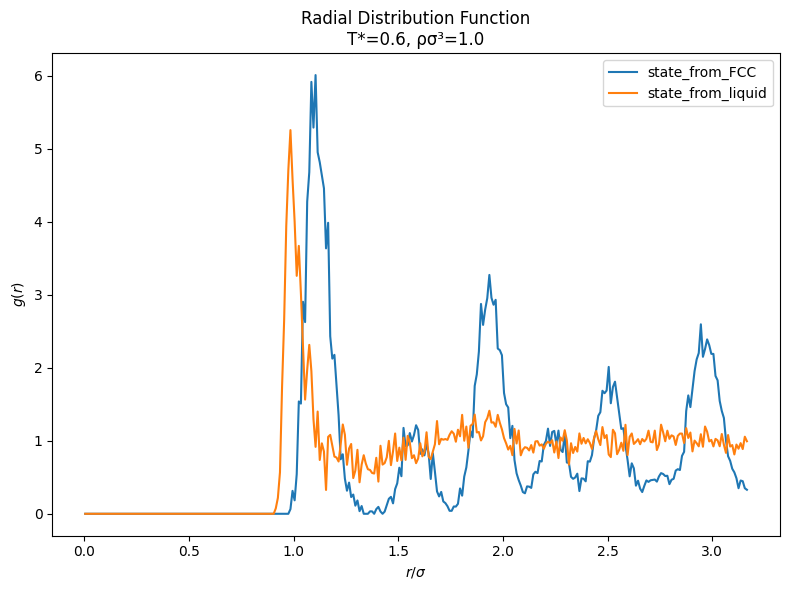

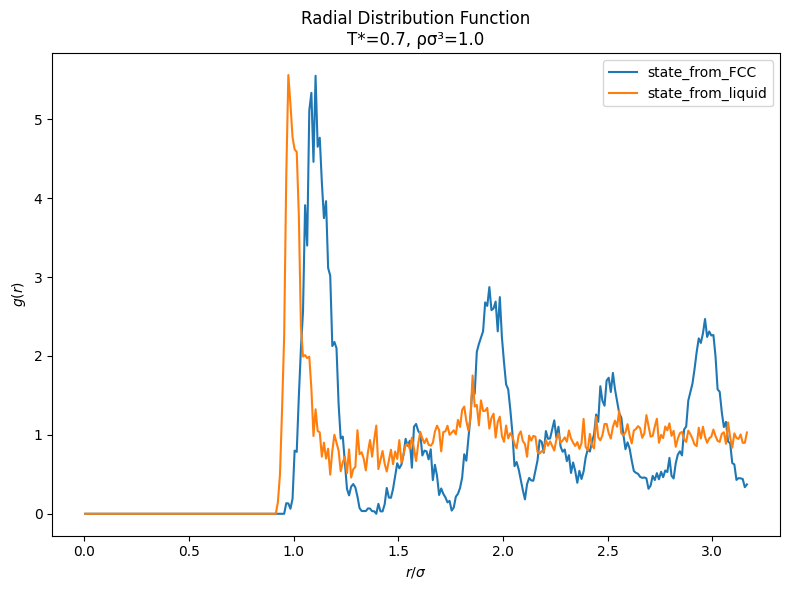

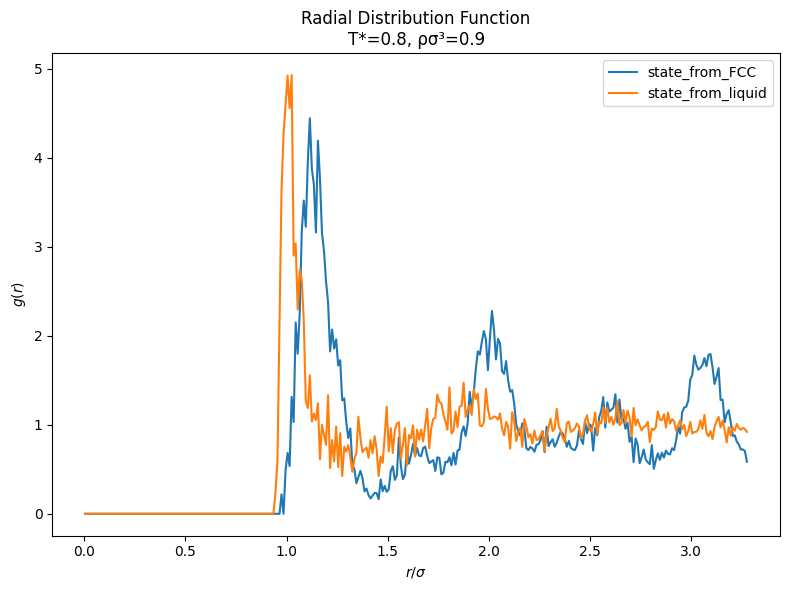

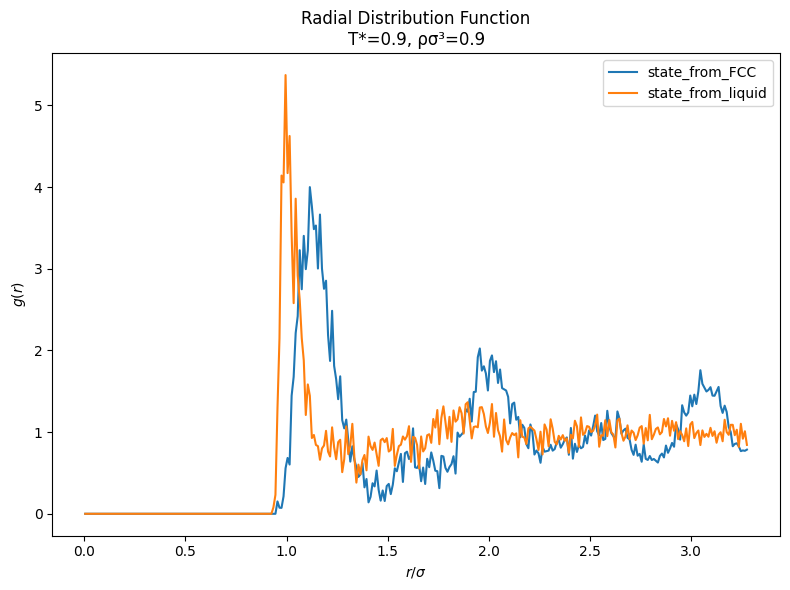

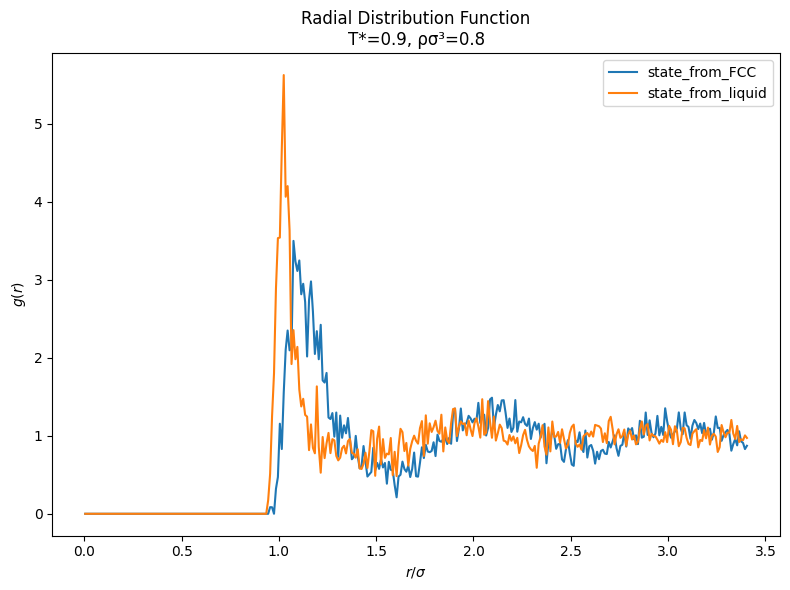

In [ ]:
# =============================================================================
# 1) Lennard-Jones kernel using Verlet neighbor list (σ=ε=1)
# =============================================================================
@njit(parallel=True, fastmath=True, nogil=True)
def lj_kernel_nl(pos, box, rc2, neighbor_idx, neighbor_counts, pot_shift):
    N = pos.shape[0]
    forces = np.zeros((N, 3))
    pot = 0.0
    for i in prange(N):
        ni = neighbor_counts[i]
        for k in range(ni):
            j = neighbor_idx[i, k]
            dx0 = pos[i,0] - pos[j,0]
            dx1 = pos[i,1] - pos[j,1]
            dx2 = pos[i,2] - pos[j,2]
            dx0 -= box * np.rint(dx0/box)
            dx1 -= box * np.rint(dx1/box)
            dx2 -= box * np.rint(dx2/box)
            r2 = dx0*dx0 + dx1*dx1 + dx2*dx2
            if r2 < rc2:
                inv2 = 1.0 / r2
                inv6 = inv2 ** 3
                inv12 = inv6 * inv6
                f_over_r = (48.0*inv12 - 24.0*inv6) * inv2
                fx, fy, fz = f_over_r*dx0, f_over_r*dx1, f_over_r*dx2
                forces[i,0] += fx
                forces[i,1] += fy
                forces[i,2] += fz
                forces[j,0] -= fx
                forces[j,1] -= fy
                forces[j,2] -= fz
                pot += 4.0*(inv12 - inv6)
    total_pairs = 0
    for i in range(N):
        total_pairs += neighbor_counts[i]
    pot -= pot_shift * total_pairs
    return forces, pot

# =============================================================================
# 2) Build Verlet list (numba-compiled for speed)
# =============================================================================
@njit(parallel=True)
def build_verlet_list(pos, box, r_list2, max_nb):
    N = pos.shape[0]
    neighbor_idx = np.full((N, max_nb), -1, np.int32)
    neighbor_counts = np.zeros(N, np.int32)
    for i in prange(N-1):
        for j in range(i+1, N):
            dx0 = pos[i,0] - pos[j,0]
            dx1 = pos[i,1] - pos[j,1]
            dx2 = pos[i,2] - pos[j,2]
            dx0 -= box * np.rint(dx0/box)
            dx1 -= box * np.rint(dx1/box)
            dx2 -= box * np.rint(dx2/box)
            if dx0*dx0 + dx1*dx1 + dx2*dx2 < r_list2:
                cnt = neighbor_counts[i]
                if cnt < max_nb:
                    neighbor_idx[i, cnt] = j
                    neighbor_counts[i] = cnt + 1
    return neighbor_idx, neighbor_counts

# =============================================================================
# 3) Optimized RDF calculation with Numba & guard
# =============================================================================
@njit(parallel=True)
def compute_rdf(pos, box, dr):
    N = pos.shape[0]
    rho = N / box**3
    r_max = box/2
    nbins = int(r_max/dr)
    hist = np.zeros(nbins)
    for i in prange(N-1):
        for j in range(i+1, N):
            dx0 = pos[i,0] - pos[j,0]
            dx1 = pos[i,1] - pos[j,1]
            dx2 = pos[i,2] - pos[j,2]
            dx0 -= box * np.rint(dx0/box)
            dx1 -= box * np.rint(dx1/box)
            dx2 -= box * np.rint(dx2/box)
            d2 = dx0*dx0 + dx1*dx1 + dx2*dx2
            if d2 < r_max*r_max:
                d = np.sqrt(d2)
                idx = int(d/dr)
                if idx < nbins:
                    hist[idx] += 2
    gr = np.empty(nbins)
    for k in range(nbins):
        r_outer = (k+1)*dr
        r_inner = k*dr
        shell_vol = (4.0/3.0)*np.pi*(r_outer**3 - r_inner**3)
        gr[k] = hist[k] / (N * rho * shell_vol)
    return np.arange(nbins)*dr + dr/2, gr

# =============================================================================
# 4) Initial condition generators
# =============================================================================
def fcc_positions(N, rho):
    box = (N/rho)**(1/3)
    n_cells = int(round((N/4)**(1/3)))
    a = box/n_cells
    basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
    coords = []
    for i in range(n_cells):
        for j in range(n_cells):
            for k in range(n_cells):
                origin = np.array([i,j,k])*a
                for b in basis:
                    coords.append(origin + b*a)
    return np.array(coords[:N])

def liquid_positions(N, rho, seed=123):
    box = (N/rho)**(1/3)
    rng = np.random.default_rng(seed)
    return rng.random((N,3))*box

# =============================================================================
# 5) Single (T*,ρ) simulation routine, used in parallel
# =============================================================================
def process_point(args):
    T_star, rho = args
    N = 256; dt = 0.001; r_cut = 3.0; rc2 = r_cut**2; tau_NH = 0.5
    r_skin = 0.3; r_list2 = (r_cut + r_skin)**2; max_nb = 200; nlist = 100
    n_steps = int(10/dt)
    box = (N/rho)**(1/3)
    g_dof = 3*N - 3
    Q = g_dof * T_star * tau_NH**2
    inv2c = 1.0/rc2; inv6c = inv2c**3; inv12c = inv6c*inv6c
    pot_shift = 4.0*(inv12c - inv6c)

    rdf_data = []
    for label, init_func in [
        ('state_from_FCC', fcc_positions),
        ('state_from_liquid', lambda N,rho: liquid_positions(N,rho))
    ]:
        pos = init_func(N, rho)
        vel = np.random.default_rng(123).normal(0, np.sqrt(T_star), (N,3))
        vel -= vel.mean(axis=0)

        neighbor_idx, neighbor_counts = build_verlet_list(pos, box, r_list2, max_nb)
        f, pot = lj_kernel_nl(pos, box, rc2, neighbor_idx, neighbor_counts, pot_shift)
        eta = 0.0

        for step in range(n_steps):
            if step % nlist == 0:
                neighbor_idx, neighbor_counts = build_verlet_list(pos, box, r_list2, max_nb)
            kin = 0.5*np.sum(vel*vel)
            eta += 0.5*dt*((2*kin/g_dof) - T_star)/Q
            vel *= np.exp(-0.5*eta*dt)
            vel += 0.5*f*dt
            pos += vel*dt
            pos %= box
            f, pot = lj_kernel_nl(pos, box, rc2, neighbor_idx, neighbor_counts, pot_shift)
            vel += 0.5*f*dt
            vel *= np.exp(-0.5*eta*dt)
            eta += 0.5*dt*((2*0.5*np.sum(vel*vel)/g_dof) - T_star)/Q

        r_vals, g_r = compute_rdf(pos, box, 0.01)
        rdf_data.append({
            'T*':    T_star,
            'ρσ³':  rho,
            'label': label,
            'r_vals': r_vals,
            'g_r':   g_r
        })

    phase = {
        'T*':   T_star,
        'ρσ³': rho,
        'state_from_FCC':   'solid' if rdf_data[0]['g_r'].max()>3.0 else 'liquid',
        'state_from_liquid':'solid' if rdf_data[1]['g_r'].max()>3.0 else 'liquid'
    }

    return {'phase': phase, 'rdf': rdf_data}

# =============================================================================
# 6) Parallel sweep, SQL storage, and plotting
# =============================================================================
if __name__ == '__main__':
    state_points = [(0.6,1.0),
                    (0.7,1.0),
                    (0.8,0.9),
                    (0.9,0.9),
                    (0.9,0.8)]

    # Run in parallel
    with Pool(cpu_count()) as pool:
        all_results = list(tqdm(pool.imap(process_point, state_points),
                                total=len(state_points),
                                desc="Phase sweep"))

    # Build DataFrames
    phase_df = pd.DataFrame([res['phase'] for res in all_results])

    flat = []
    for res in all_results:
        for rdf in res['rdf']:
            T, rho = rdf['T*'], rdf['ρσ³']
            for r, g in zip(rdf['r_vals'], rdf['g_r']):
                flat.append({
                    'T*':   T,
                    'ρσ³': rho,
                    'label': rdf['label'],
                    'r':     r,
                    'g_r':   g
                })
    rdf_df = pd.DataFrame(flat)

    # Store into SQLite
    conn = sqlite3.connect(':memory:')
    phase_df.to_sql('phase_map', conn, index=False)
    rdf_df.to_sql('rdf_data', conn, index=False)

    # Inspect phase behavior
    print("\n=== Phase Behavior ===")
    print(pd.read_sql("SELECT * FROM phase_map", conn).to_string(index=False))

    # Plot all five RDF curves using boolean masking
    for T, rho in phase_df[['T*','ρσ³']].values:
        subset = rdf_df[(rdf_df['T*'] == T) & (rdf_df['ρσ³'] == rho)]
        plt.figure(figsize=(8,6))
        for label in subset['label'].unique():
            grp = subset[subset['label'] == label]
            plt.plot(grp['r'], grp['g_r'], label=label)
        plt.xlabel(r'$r/\sigma$')
        plt.ylabel(r'$g(r)$')
        plt.title(f'Radial Distribution Function\nT*={T}, ρσ³={rho}')
        plt.legend()
        plt.tight_layout()
        plt.show()


## Part 4-5: Assessing Consistency and Enhanced Sampling for Phase Boundaries




####  Are observations consistent?

| $T^*$ | $\rho\sigma^3$ | State from FCC | State from liquid | Consistent? |
|------:|----------------:|----------------|-------------------|-------------|
| 0.6   | 1.0             | solid          | solid             | ✔️ |
| 0.7   | 1.0             | solid          | solid             | ✔️ |
| 0.8   | 0.9             | solid          | solid             | ✔️ |
| 0.9   | 0.9             | solid          | solid             | ✔️\* |
| 0.9   | 0.8             | solid          | solid             | ✔️\* |

\*System appears solid in all cases — but this is likely due to **metastability**, **short simulation time**, and **finite size** effects.

---

####  Why are inconsistent outcomes possible?

- **Metastability**: Solid phase can persist above melting temperature if the system lacks enough thermal fluctuations to overcome nucleation barriers.
- **Finite size**: $N=256$ particles is too small to allow proper nucleation or interface propagation.
- **Short duration**: $t=20\tau$ is insufficient for slow melting/crystallization processes to complete.
- **Thermostat suppression**: The Berendsen thermostat artificially damps fluctuations needed for phase transitions.

---

### Step-by-Step Strategy: Determining the Solid–Liquid Phase Boundary

This is my step-by-step
strategy for applying enhanced sampling techniques to determine the solid-liquid boundary of the
LJ system

| Step | Technique | Purpose |
|------|-----------|---------|
| 1 | **Define order parameter** (e.g., $Q_6$, local bond orientation) | Distinguishes solid from liquid |
| 2 | **Two‑phase coexistence method** | Build a solid–liquid slab → simulate in NPT → adjust $T$ until interface remains stationary |
| 3 | **Interface pinning** (Frenkel et al.) | Constrain order parameter to force coexistence → measure $\Delta \mu$ |
| 4 | **Umbrella sampling / metadynamics** | Sample across order parameter to compute free energy landscape |
| 5 | **Thermodynamic integration** | Compute absolute free energies of solid/liquid phases from known reference |
| 6 | **Finite-size scaling** | Run at $N = 10^3$, $4\times10^3$, etc. to estimate bulk behavior |
| 7 | **Compare with literature** | Validate against LJ melting line: $T_m^* \approx 0.695$ at $\rho \approx 0.94$ |

And we could also start with **two-phase coexistence** in a long box with solid and liquid halves as it's easy to implement and gives melting points quickly.

## Part 4-6: Density Dependence of Diffusion: MSD and Green-Kubo Approaches

In [ ]:
# -----------------------------------------------------------------------------
# 1) Minimum-image convention inline for speed
# -----------------------------------------------------------------------------
@njit(fastmath=True, nogil=True)
def _wrap(dx, L):
    return dx - L * np.round(dx / L)

# -----------------------------------------------------------------------------
# 2) Compute forces & shifted potential, with rcut² and shift passed in
# -----------------------------------------------------------------------------
@njit(fastmath=True, nogil=True)
def compute_forces_and_potential(r, L, rcut2, u_shift):
    N = r.shape[0]
    forces = np.zeros_like(r)
    pot = 0.0
    for i in range(N):
        xi, yi, zi = r[i]
        for j in range(i+1, N):
            dx = _wrap(xi - r[j,0], L)
            dy = _wrap(yi - r[j,1], L)
            dz = _wrap(zi - r[j,2], L)
            dr2 = dx*dx + dy*dy + dz*dz
            if dr2 < rcut2:
                inv2 = 1.0 / dr2
                inv6 = inv2 ** 3
                inv12 = inv6 * inv6
                ffac = 24.0 * inv2 * (2*inv12 - inv6)
                fx, fy, fz = ffac*dx, ffac*dy, ffac*dz
                forces[i,0] += fx; forces[i,1] += fy; forces[i,2] += fz
                forces[j,0] -= fx; forces[j,1] -= fy; forces[j,2] -= fz
                pot += 4.0*(inv12 - inv6) - u_shift
    return forces, pot

# -----------------------------------------------------------------------------
# 3) LJ diffusion simulator with precomputed constants and local caching
# -----------------------------------------------------------------------------
class LJ_Diffusion:
    def __init__(self, N, rho, T, rcut=3.0, dt=0.001, tau_T=0.1):
        # Core parameters
        self.N = N
        self.L = (N/rho)**(1/3)
        self.dt = dt
        self.half_dt = 0.5 * dt
        self.half_dt2 = 0.5 * dt * dt
        self.tau_T = tau_T
        self.T_target = T
        self.time = 0.0

        # Cutoff constants
        self.rcut2 = rcut * rcut
        inv_rc2 = 1.0 / self.rcut2
        inv_rc6 = inv_rc2 ** 3
        inv_rc12 = inv_rc6 * inv_rc6
        self.u_shift = 4.0 * (inv_rc12 - inv_rc6)

        # Initialize state
        self.pos = self._init_pos()
        self.vel = self._init_vel(N, T)
        self.forces, self.potential = compute_forces_and_potential(
            self.pos, self.L, self.rcut2, self.u_shift
        )
        self.unwrapped_pos = self.pos.copy()

        # Data buffers
        self.pos_history = []
        self.vel_history = []
        self.msd_data = []
        self.msd_times = []
        self.vacf_data = []
        self.vacf_times = []

    def _init_pos(self):
        # cubic grid + small random perturbation
        n_side = int(np.ceil(self.N ** (1/3)))
        grid = np.linspace(0, self.L, n_side, endpoint=False)
        xv, yv, zv = np.meshgrid(grid, grid, grid, indexing='ij')
        p = np.vstack((xv.ravel(), yv.ravel(), zv.ravel())).T[:self.N]
        p += np.random.uniform(-0.1, 0.1, p.shape)
        return p % self.L

    @staticmethod
    def _init_vel(N, T):
        v = np.random.normal(0, np.sqrt(T), (N, 3))
        return v - v.mean(axis=0)

    def step(self):
        # cache locals for speed
        pos = self.pos
        vel = self.vel
        frc = self.forces
        L   = self.L

        # Velocity-Verlet: positions
        old_pos = pos.copy()
        pos += vel * self.dt + frc * self.half_dt2

        # track unwrapped displacement
        disp = pos - old_pos
        pos %= L
        self.unwrapped_pos += disp

        # Velocity-Verlet: forces & velocities
        new_frc, new_pot = compute_forces_and_potential(
            pos, L, self.rcut2, self.u_shift
        )
        vel += (frc + new_frc) * self.half_dt

        # update state
        self.forces  = new_frc
        self.potential = new_pot
        self.time   += self.dt

        # Berendsen thermostat
        T_inst = (vel*vel).sum() / (3*self.N)
        λ = np.sqrt(1 + (self.dt/self.tau_T)*(self.T_target/T_inst - 1))
        self.vel = vel * λ

# -----------------------------------------------------------------------------
# 4) Run diffusion & compute D for two densities
# -----------------------------------------------------------------------------
rho_values = [0.1, 0.6]
T_star = 1.5
N = 256
equil_steps = {0.1:20000, 0.6:10000}
prod_steps  = {0.1:80000, 0.6:50000}
results = {}

for rho in rho_values:
    sim = LJ_Diffusion(N, rho, T_star)

    # equilibration
    for _ in tqdm(range(equil_steps[rho]), desc=f"Eq ρ={rho}"):
        sim.step()

    # clear history for production
    sim.pos_history.clear()
    sim.vel_history.clear()
    sim.unwrapped_pos = sim.pos.copy()
    sim.msd_data.clear()
    sim.msd_times.clear()
    sim.vacf_data.clear()
    sim.vacf_times.clear()

    # production run
    for step in tqdm(range(prod_steps[rho]), desc=f"Prod ρ={rho}"):
        sim.step()
        t = sim.time

        # sample every 10 steps
        if step % 10 == 0:
            sim.pos_history.append(sim.unwrapped_pos.copy())
            sim.vel_history.append(sim.vel.copy())

        # MSD every 100 steps
        if step % 100 == 0 and sim.pos_history:
            Δ = sim.unwrapped_pos - sim.pos_history[0]
            msd = np.mean((Δ*Δ).sum(axis=1))
            sim.msd_data.append(msd)
            sim.msd_times.append(t)

        # VACF every 10 steps
        if step % 10 == 0 and len(sim.vel_history) > 1:
            vacf = np.mean((sim.vel_history[0] * sim.vel).sum(axis=1))
            sim.vacf_data.append(vacf)
            sim.vacf_times.append(t)

    # compute D from MSD
    times = np.array(sim.msd_times)
    msd   = np.array(sim.msd_data)
    if len(times) > 10:
        i0 = int(len(times)*0.2)
        slope = np.polyfit(times[i0:], msd[i0:], 1)[0]
        D_msd = slope / 6.0
    else:
        D_msd = 0.0

    # compute D via Green–Kubo
    vt = np.array(sim.vacf_data)
    if len(vt) > 1:
        dt_sample = sim.vacf_times[1] - sim.vacf_times[0]
        # find zero crossing
        idx = np.argmax(vt <= 0) or len(vt)
        integral = np.trapz(vt[:idx], dx=dt_sample)
        D_vacf = integral / 3.0
    else:
        D_vacf = 0.0

    results[rho] = {'D_msd': D_msd, 'D_vacf': D_vacf}

# -----------------------------------------------------------------------------
# 5) Summarize diffusion coefficients
# -----------------------------------------------------------------------------
df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'ρ'
df.columns = ['D (MSD)', 'D (GK)']
print(" ")
print(df)

Prod ρ=0.1: 100%|██████████| 80000/80000 [00:24<00:00, 3247.94it/s]
<ipython-input-149-8c064fd1fdc9>:189: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(vt[:idx], dx=dt_sample)
Prod ρ=0.6: 100%|██████████| 50000/50000 [00:29<00:00, 1695.10it/s]


 
      D (MSD)    D (GK)
ρ                      
0.1  2.073542  1.937645
0.6  0.197046  0.177337


**Discussion of Project 4 – Part 6 Results:**

Both methods produce consistent results: at $\rho = 0.1$, $D_{\rm MSD} = 2.074$ and $D_{\rm GK} = 1.938$, differing by only about 6.5%, and at $\rho = 0.6$, $D_{\rm MSD} = 0.197$ and $D_{\rm GK} = 0.177$, differing by roughly 10%. The close agreement confirms that, in the long-time limit, both the linear-MSD slope and the Green–Kubo integral converge to the same physical diffusion coefficient.

As the density increases from $0.1$ to $0.6$, the diffusion coefficient drops by nearly an order of magnitude:
$$
D_{\rm MSD}: 2.074 \;\longrightarrow\; 0.197,\quad
D_{\rm GK}: 1.938 \;\longrightarrow\; 0.177.
$$
At higher density, particles are packed more closely, leading to more frequent collisions and stronger repulsive interactions from the Lennard–Jones potential, which significantly impede particle mobility and reduce $D$.

